In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random
from math import sqrt
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
start_hour = 5
end_hour = 10

In [31]:
meta = pd.read_csv('calibration_data/Traffic_Counts_by_Study_20240122.csv')
hourly_data = pd.read_csv('calibration_data/Traffic_Count_Studies_by_Hour_Bins_20240122.csv')

# reading the demand in a csv file. the result of second step of demand generation (TAZ conversion)
demand_data = pd.read_csv('psrc_vehicle_trips_converted_taz_calibrated.csv')  # Use after making changes in step2

# reading loop detector xml data in the simulation
# sim_loops = ET.parse('calibration_data/loops.xml').getroot().findall('interval')
sim_loops = ET.parse('calibration_data/loops_Feb29.xml').getroot().findall('interval')

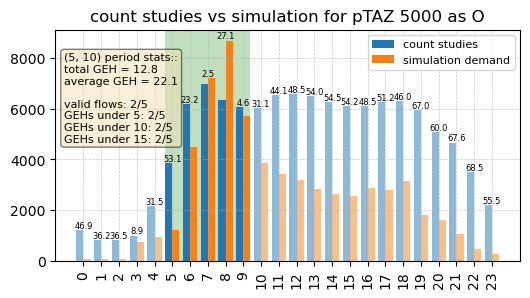

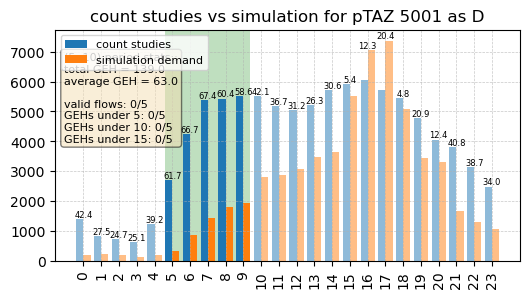

----------


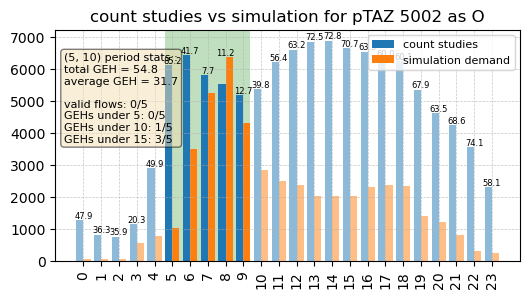

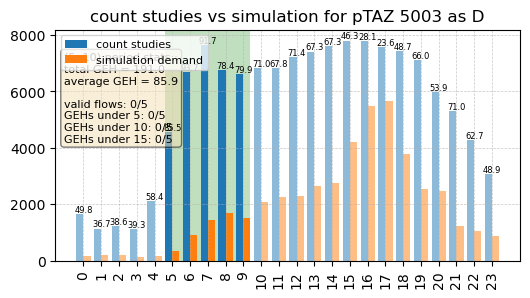

----------


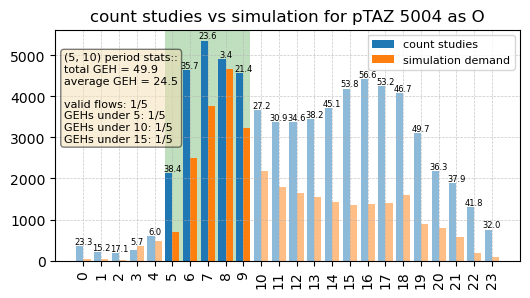

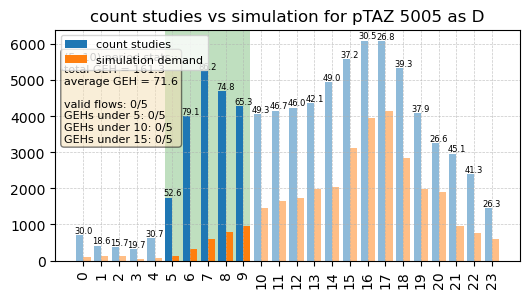

----------


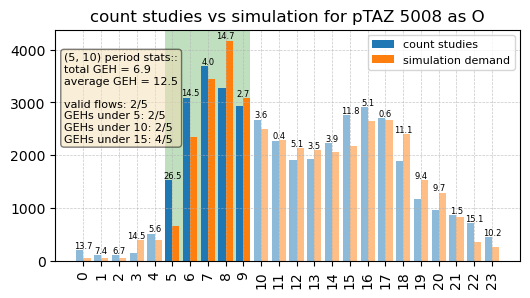

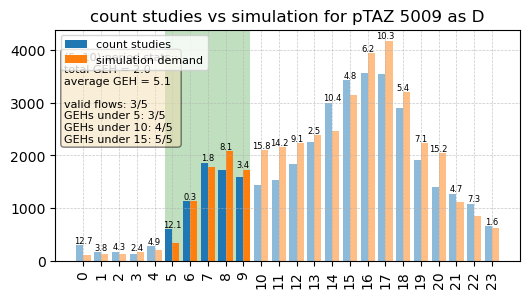

----------


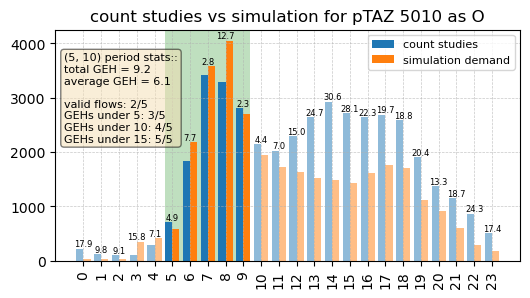

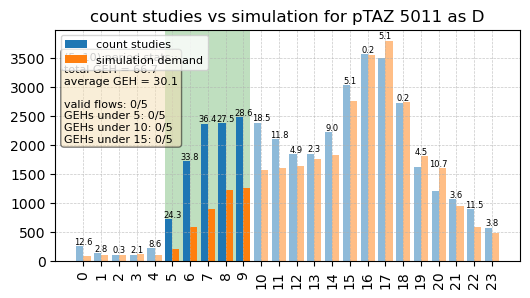

----------


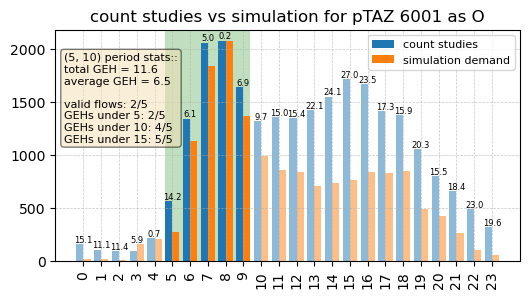

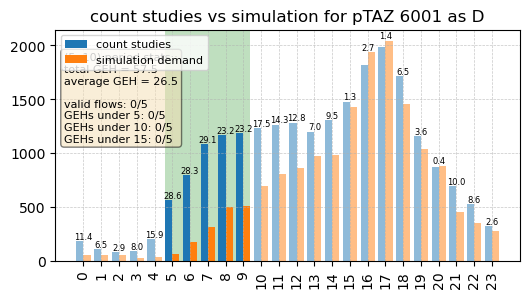

----------


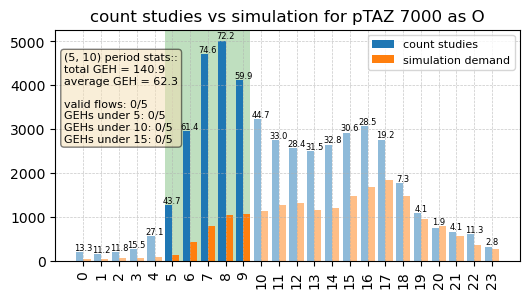

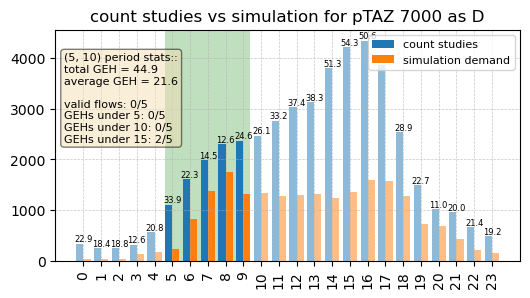

----------


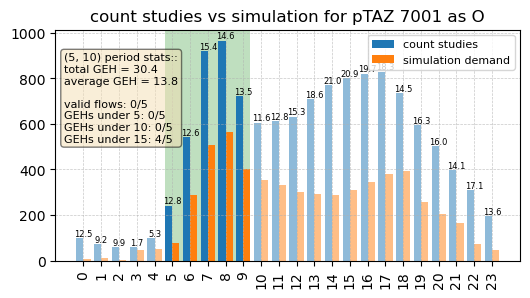

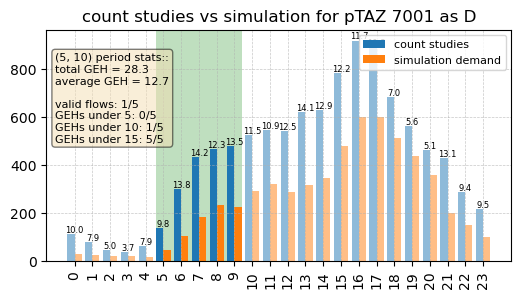

----------


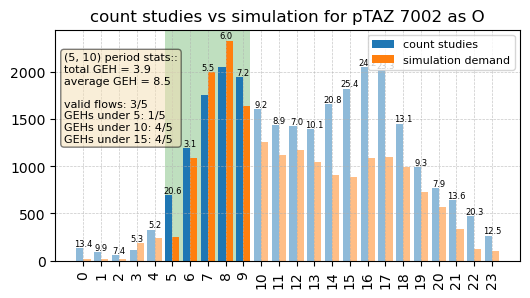

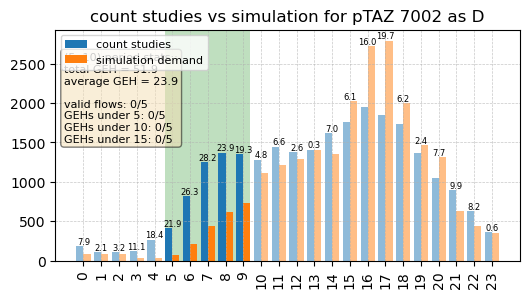

----------


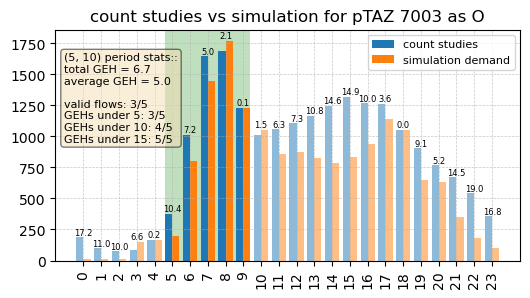

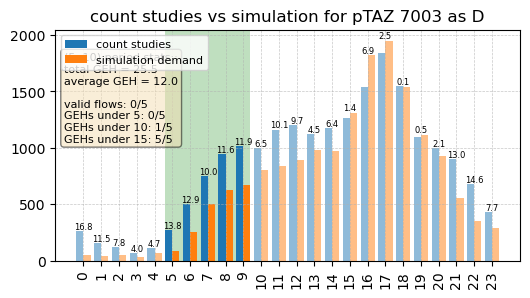

----------


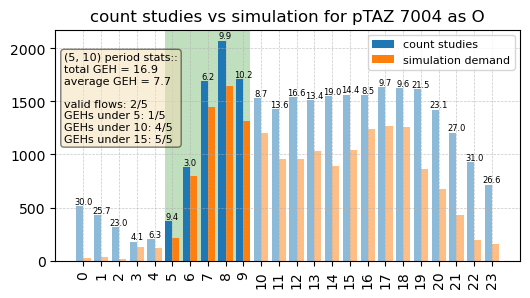

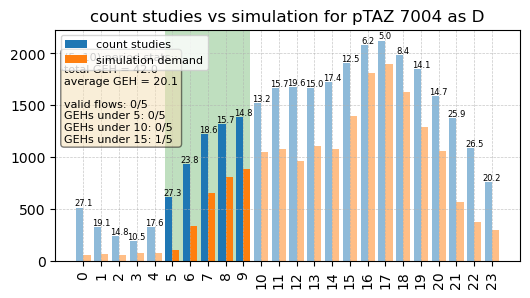

----------


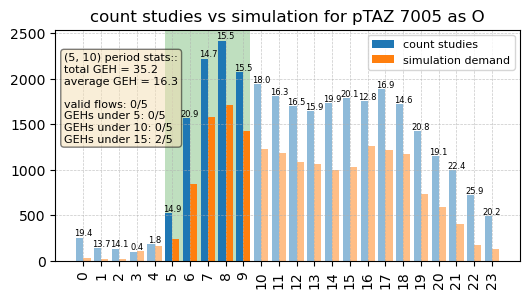

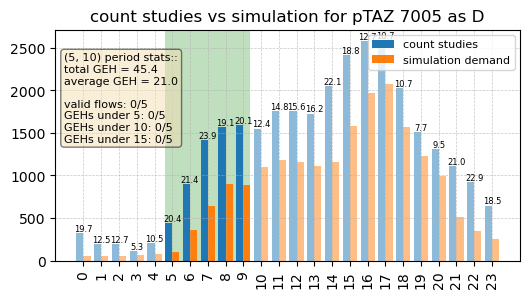

----------


In [32]:
# demand_data = pd.read_csv('psrc_vehicle_trips_converted_taz.csv')  # Use after making changes in step2
show_all_pTAZs(demand_data)

In [7]:
# used for count studies data processing
cols_to_keep = ['STUDY_ID','TOTAL',
                'HR01_TOTAL', 'HR02_TOTAL', 'HR03_TOTAL', 'HR04_TOTAL', 'HR05_TOTAL',
               'HR06_TOTAL', 'HR07_TOTAL', 'HR08_TOTAL', 'HR09_TOTAL', 'HR10_TOTAL',
               'HR11_TOTAL', 'HR12_TOTAL', 'HR13_TOTAL', 'HR14_TOTAL', 'HR15_TOTAL',
               'HR16_TOTAL', 'HR17_TOTAL', 'HR18_TOTAL', 'HR19_TOTAL', 'HR20_TOTAL',
               'HR21_TOTAL', 'HR22_TOTAL', 'HR23_TOTAL', 'HR24_TOTAL', 'AM_PK_VOL',
               'AM_PK_HOUR', 'AM_PK_FAC', 'AM_15_HIGH', 'PM_PK_VOL', 'PM_PK_HOUR',
               'PM_PK_FAC', 'PM_15_HIGH', 'MAX_8_VOL', 'MAX_8_TIME', 'MAX_8_FAC']
agg_func = {col:((lambda x: x.mode().iloc[0]) if col[-4:] in ['TIME', 'HOUR', 'HIGH'] else 'mean') for col in cols_to_keep}

In [8]:
len(demand_data)

680012

### Finding useful studies

In [17]:
year = meta[meta.START_DATE.str.contains('|'.join(['2015','2016','2017', '2018', '2019']))]
# year = meta[meta.START_DATE.str.contains('|'.join(['2019']))]

name = year[year.TITLE.str.contains('2ND AVE W, N/O W MERCER ST; ', case=False)]
name.loc[:,['STUDY_ID','TITLE']]
# for i in name.TITLE:
#     print(i)
 

STUDY_ID  \
39778    328365   
46890    328378   
47740    328364   

                                                                  TITLE  
39778   2ND AVE W, N/O W MERCER ST; S FLOW; CHSENSOR A; 28Jun2018 09:45  
46890  2ND AVE W, N/O W MERCER ST; TOTAL FLOW; CH(AGG); 28Jun2018 09:45  
47740   2ND AVE W, N/O W MERCER ST; N FLOW; CHSENSOR A; 28Jun2018 09:45

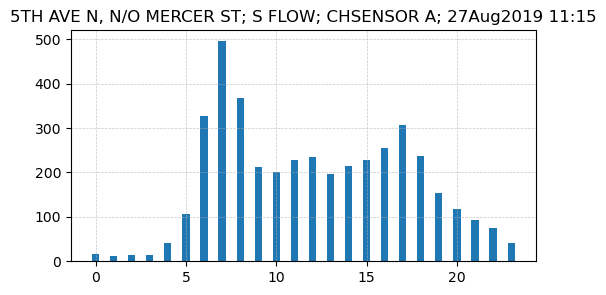

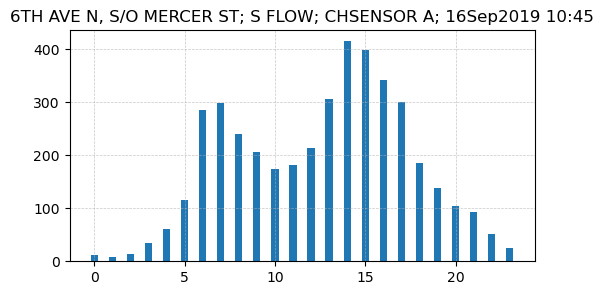

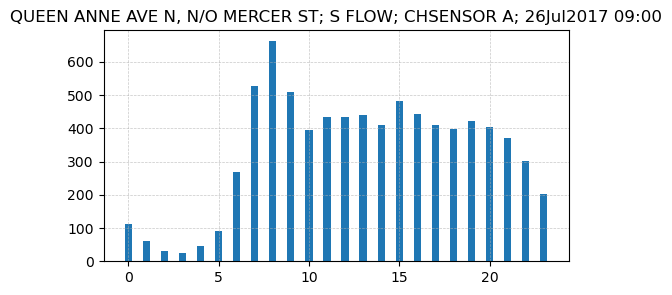

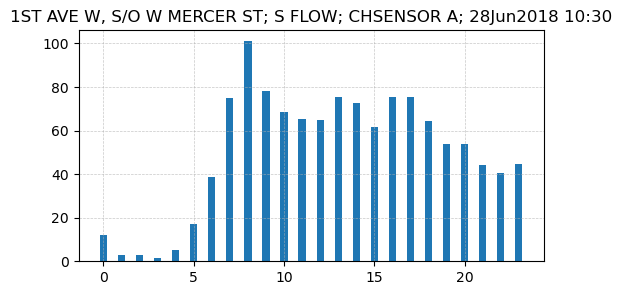

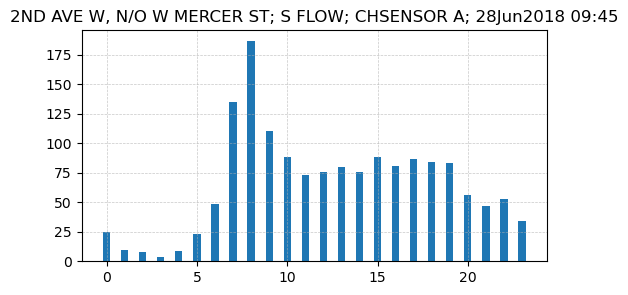

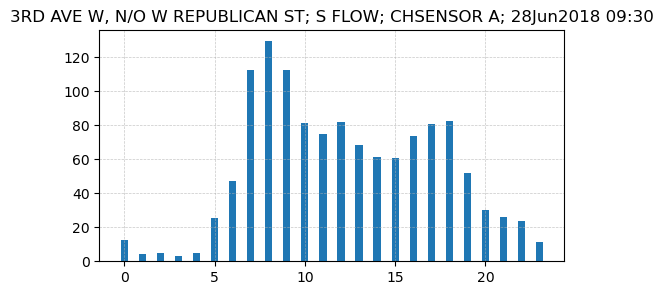

{0: 189.16666666666666,
 1: 99.66666666666667,
 2: 77.33333333333334,
 3: 81.33333333333333,
 4: 168.16666666666669,
 5: 378.1666666666667,
 6: 1014.8333333333333,
 7: 1644.5,
 8: 1685.3333333333335,
 9: 1231.3333333333333,
 10: 1007.3333333333334,
 11: 1055.8333333333333,
 12: 1108.0,
 13: 1167.6666666666667,
 14: 1248.6666666666665,
 15: 1319.8333333333335,
 16: 1269.0,
 17: 1263.5,
 18: 1054.0,
 19: 902.5,
 20: 767.3333333333334,
 21: 673.5,
 22: 544.6666666666667,
 23: 357.33333333333337}

In [18]:
get_count_study(7003, show_separate=True, destination_TAZ=False)

### count studies should be doubled check

In [9]:
## look at previous sections for title of each studyID

## for inflow to the network
demand_study_dict_origin = {6001: [322483],
             7000: [333868, 320924, 324519, 318994],
             7001: [322813, 324362, 331428, 332269], 
             7002: [332512, 320510, 320532, 324825],  
             7003: [332184, 332592, 323870, 328373, 328365, 328363], 
             7004: [329133, 326627, 332936, 333111, 332535], 
             7005: [321422, 320154, 329144, 327226, 329133]}

    
## for outflow of the network
demand_study_dict_dest = {6001: [322482],
             7000: [333869, 330820, 324302, 318995],
             7001: [322812, 324361, 331427, 332265],  
             7002: [324827, 320531, 320509, 332512, 321121],
             7003: [332195, 332594, 314796, 323869, 328371, 328362], 
             7004: [331094, 326626, 332940, 333110, 332536], 
             7005: [321116, 320155, 329142, 327225, 331094]}


corridor_study_dict = {'denny_e1': 327937,  'denny_e2': 332405,  'denny_e3': 332485,  
                       'denny_w3': 327938,  'denny_w2':332404,'denny_w1': 332486, 
                       'yesler_e2':326650, 'yesler_e1':329389, 'yesler_w1':326651, 'yesler_w2':329391,
                       'boren_se1':332078, 'boren_se2':332747, 'boren_se3':332082, 
                       'boren_nw3':332077, 'boren_nw2':332876, 'boren_nw1':332081, 
                       'pine_e1':328588, 'pine_e2':330544, 'pine_w1':330545, 'pine_w2':328589,'pine_w3':331119, 
                       'stewart_w1':327941, 'seven_n1':332787, 'seven_s1':332788, 
                       'first_se3': 332062, 'first_se2': 332029, 'first_se1': 330712, 
                       'first_nw3': 330717, 'first_nw2': 332030 ,'first_nw1': 332063}



# draw barplots for real and simulation data

### define functions

In [10]:
def get_period_stats(observation_simulation_pairs):
    '''
    checking GEH and flow validation (options i, ii, iii, and v in the criteria table)
    '''
    # in this function, we calculate GEH for selected period and check other criteria for calibration
#     validation_dict = {key:[], for key in observation_simulation_pairs.keys()}
    GEHs = {}
    flow_validation = {}
    gehU5, gehU10, gehU15 = 0, 0, 0


    for key,pair in observation_simulation_pairs.items():
        field = pair[0]
        model = pair[1]
        # check GEH
        GEH = sqrt(2*((model-field)**2)/(model+field))
        GEHs[key] = GEH
        if GEH<=15:
            gehU15+=1
        if GEH<=10:
            gehU10+=1
        if GEH<=5:
            gehU5+=1

        # check hourly flow 
        valid_flow = False
        difference = abs(model-field)
        if field<700:  # option a.i
            if difference<=100:
                valid_flow=True
        elif field<2700:  # option a.ii
            if difference<=0.15*field:
                valid_flow=True
        elif field>=2700:  # option a.iii
            if difference<=400:
                valid_flow=True
        flow_validation[key] = valid_flow            
#     return [GEHs, flow_validation, gehU15, gehU10, gehU5]
    n = len(observation_simulation_pairs)
    return f'valid flows: {sum(list(flow_validation.values()))}/{n} \nGEHs under 5: {gehU5}/{n} \nGEHs under 10: {gehU10}/{n} \nGEHs under 15: {gehU15}/{n}' 

In [11]:
def get_GEH(field_dict, model_dict, start_end = None):
    '''
    given hourly volumes of observation and simulation,
    this function gives us GEH for each hour, selected period, and all given hours 
    '''
    ans = {'hourly':{}, 'total':None, 'period':None, 'period_hours':{}}
    period_validation_stats = None
    
    period_real_sim_pairs = {}
    field_sum = 0
    model_sum = 0
    field_period = 0
    model_period = 0
    all_GEH=[]
    selected_GEH=[]
    for key in field_dict.keys():
        field = field_dict[key]
        model = model_dict.get(key, 0)
        GEH = sqrt(2*((model-field)**2)/(model+field))
        ans['hourly'][key]=round(GEH,1)
        all_GEH.append(GEH)
        
        field_sum += field
        model_sum += model
        if (start_end is not None) and (key>=start_end[0]) and (key<start_end[1]):
            period_real_sim_pairs[key] = (field, model)
#             ans['period_hours'][key]=round(GEH,1)
            field_period += field
            model_period += model
            selected_GEH.append(GEH)
            
    if start_end is not None:
        period_validation_stats = get_period_stats(period_real_sim_pairs)
        period_total_GEH = sqrt(2*((model_period-field_period)**2)/(model_period+field_period))
        period_average_GEH = np.mean(selected_GEH)
        ans['period'] = [round(period_total_GEH, 1), round(period_average_GEH, 1)]
        
    total_GEH = sqrt(2*((model_sum-field_sum)**2)/(model_sum+field_sum))
    total_average_GEH = np.mean(all_GEH)
    ans['total'] = [round(total_GEH, 1), round(total_average_GEH, 1)]
    return ans, period_validation_stats

   #### Is the calculation correct? which one to choose?

In [29]:
def draw_barplot(dictData, title, label=None, dictData2=None, label2=None, 
                 start_end = None, show_stats=False):
    width = 0.4
    plt.figure(figsize=(6, 3))
        
    plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)
    
    if start_end is not None:
        if dictData2 is None:
            plt.axvspan(start_end[0], start_end[1]-1, color='green', alpha=0.25, lw=0)
        else:
            plt.axvspan(start_end[0]-width/2, start_end[1]-1+3*width/2, color='green', alpha=0.25, lw=0)
            
    d1idx = np.array(list(dictData.keys()))
    bar1 = plt.bar(d1idx, dictData.values(), width, label=label)
    
    if dictData2 is not None:
        ## ADDING SECOND BAR PLOT
        d2idx = np.array(list(dictData2.keys()))
        bar2 = plt.bar(d2idx+width, dictData2.values(), width, label=label2)
        plt.legend(fontsize="8")
        plt.xticks(d2idx+width/2, d2idx, rotation=90) 
        
        ## ADDING GEH STATISTICS
        GEH, period_stats = get_GEH(dictData, dictData2, start_end)            
        
        ### writing GEH for all hours 
        if not show_stats:  # we don't want our plots too messy!
            text1 = '\n'.join(['All hours GEH:', f"total = {GEH['total'][0]}", f"average = {GEH['total'][1]}"])
            plt.text(0.5+plt.gca().get_xlim()[0], 
                     0.95*plt.gca().get_ylim()[1],
                     text1, fontsize=8, verticalalignment='top', 
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.25))
        ### writing GEH for selected hours 
        if start_end is not None:
            text2 = '\n'.join([f'{start_end} period stats::', f"total GEH = {GEH['period'][0]}", f"average GEH = {GEH['period'][1]}"])
            y_adj = 0.75
            if show_stats:
                text2 = text2 + '\n\n'+ period_stats
                y_adj = 0.90
            plt.text(0.5+plt.gca().get_xlim()[0], 
                     y_adj*plt.gca().get_ylim()[1],
                     text2, fontsize=8, verticalalignment='top', 
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
                
        ### writing hourly GEH    
        for i in range(len(d2idx)):
            hour = d2idx[i]
            fieldBar = bar1[i+d2idx[0]]
            modelBar = bar2[i]
            x = fieldBar.get_x() + width
            y = max(fieldBar.get_height(), modelBar.get_height())          
            plt.text(x, y, f"{GEH['hourly'][hour]}", ha='center', va='bottom', fontsize=6)
            if start_end is not None:
                if (hour < start_end[0]) or (hour>=start_end[1]):
                    fieldBar.set_alpha(0.5)
                    modelBar.set_alpha(0.5)


    plt.title(title)
    plt.show()

In [13]:
def get_simulation_origin_dist(otaz=None, dtaz=None, show_separate=False, demand_df=demand_data):
    demand_copy = demand_df.copy()
    if otaz is not None:
        demand_copy = demand_copy[demand_copy.otaz==otaz]
    if dtaz is not None:
        demand_copy = demand_copy[demand_copy.dtaz==dtaz]
        
    departure_times = demand_copy.deptm//60
    dic = {hour:sum(departure_times==hour) for hour in range(24)}
    if show_separate:
        if (otaz is not None) and (dtaz is None):
            draw_barplot(dic, f'Total simulation volume FROM {otaz}')
        elif (otaz is None) and (dtaz is not None):
            draw_barplot(dic, f'Total simulation volume INTO {dtaz}')
        elif (otaz is not None) and (dtaz is not None):
            draw_barplot(dic, f'Total simulation volume from O:{otaz} to D:{dtaz}')
                       
    return dic

In [14]:
def get_count_study(taz_num, show_separate=False, corridor_check=False, destination_TAZ=False):
    hourly_vols = [0]*24
    if corridor_check:
        study_ids = corridor_study_dict[taz_num]
    elif destination_TAZ:
        study_ids = demand_study_dict_dest[taz_num]
    else:
        study_ids = demand_study_dict_origin[taz_num]
    if type(study_ids)==int:
        study_ids = [study_ids]
    for study_id in study_ids:
        title = meta[meta.STUDY_ID==study_id].TITLE.values[0]
        study_df = hourly_data[hourly_data.STUDY_ID==study_id][~hourly_data.WEEKDAY.isin([1,2,6,7])][hourly_data.HOLIDAY_YN=='N']
        study_df = study_df[cols_to_keep]

        study_grouped = study_df.groupby(by='STUDY_ID').agg(agg_func)
        hourly_vol = list(study_grouped.iloc[0, 2:26])
        hourly_vols = [x+y for x,y in zip(hourly_vols, hourly_vol)]
        
        if show_separate:
            dict_data = {hour:hourly_vol[hour] for hour in range(0, 24)}
            draw_barplot(dict_data, title)

    return {hour:hourly_vols[hour] for hour in range(0, 24)}

In [15]:
tracflow_dict = {5000:['i5n/', ['005es16640_MS__ TWTh 2017-2019 _60m',
                               '005es16640_MSH_ TWTh 2017-2019 _60m']],
                 5001:['i5n/', ['005es16704_MN__ TWTh 2017-2019 _60m']],
                 5002:['I5S/', ['005es16395_MN__ TWTh 2018 _60m',
                                '005es16395_MNH_ TWTh 2018 _60m']],
                 5003:['I5S/', ['005es16396_MSH_ TWTh 2018 _60m',
                                '005es16396_MS__ TWTh 2018 _60m']], 
                 5004:['I90/', ['090es00302_MW__ TWTh 2018 _60m']], 
                 5005:['I90/', ['090es00302_ME__ TWTh 2018 _60m',
                                '090es00302_ME_X TWTh 2018 _60m']], 
                 5008:['SR99S/', ['099es02951_MN__ TWTh 2019 _60m']], 
                 5009:['SR99S/', ['099es02951_MS__ TWTh 2019 _60m']], 
                 5010:['SR99N/',['099es03271_MS_X TWTh 2018-2019 _60m',
                                 '099es03271_MS__ TWTh 2018-2019 _60m']], 
                 5011:['SR99N/', ['099es03271_MN__ TWTh 2018-2019 _60m',
                                  '099es03271_MN_O TWTh 2018-2019 _60m']]}

def get_tracflow_vol(taz, show_separate=False):
    foldername = tracflow_dict[taz][0]
    datalist = []
    for file_name in tracflow_dict[taz][1]:
        df = pd.read_excel('calibration_data/'+foldername+file_name+'.xlsx')['Mean Volume'][:24]
        if show_separate:
            df.plot.bar(title=f"{taz}  - {foldername[:-1]}\n {file_name}",
                        figsize=(6, 3), grid=True)
            plt.show()
        datalist.append(df)
    data = datalist[0]
    for i in range(1, len(datalist)):
        data += datalist[i]
        
    return data.to_dict()

## for pTAZs inflow to the network 

### pTAZs w/o highways

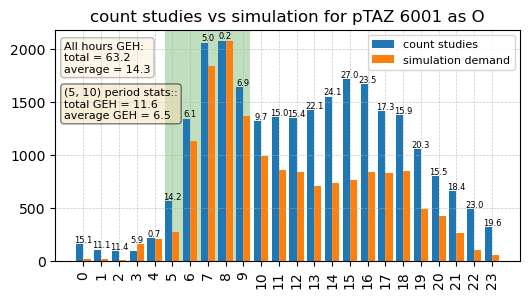

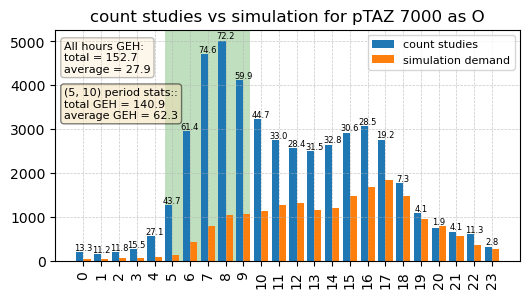

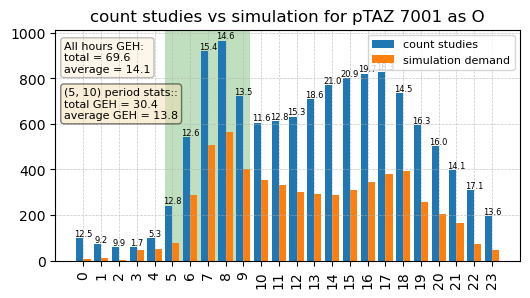

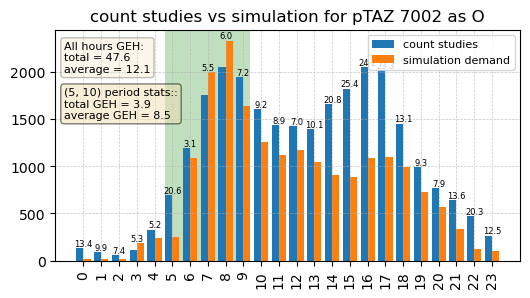

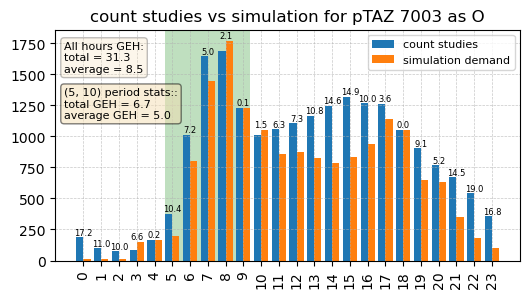

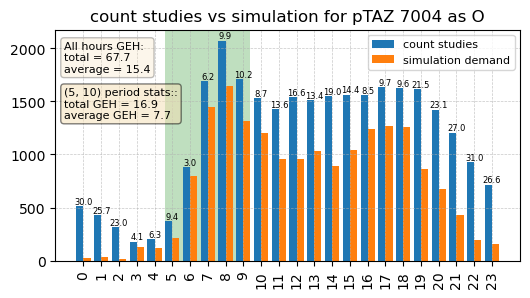

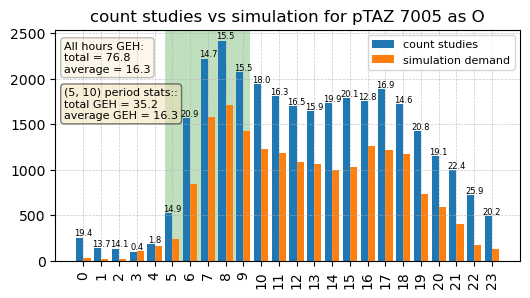

In [69]:
origins=[6001, 7000, 7001, 7002, 7003, 7004, 7005]

for o in origins:
    countDict = get_count_study(o, show_separate=False)
    # Just the count data
#     draw_barplot(countDict, f'Total volume for the list of count studies {o}') 
    
    # adding simulation data:
    simDict = get_simulation_origin_dist(otaz=o, show_separate=False)
    draw_barplot(dictData=countDict, label='count studies', 
                 dictData2=simDict, label2='simulation demand',
                 title=f'count studies vs simulation for pTAZ {o} as O', start_end=(start_hour, end_hour))    


### pTAZs with highways

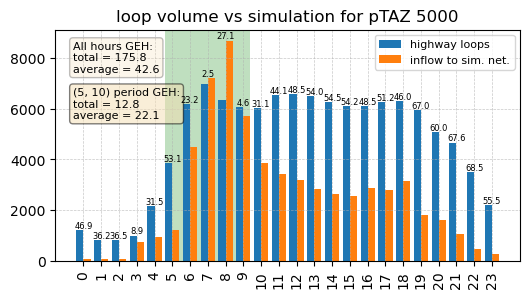

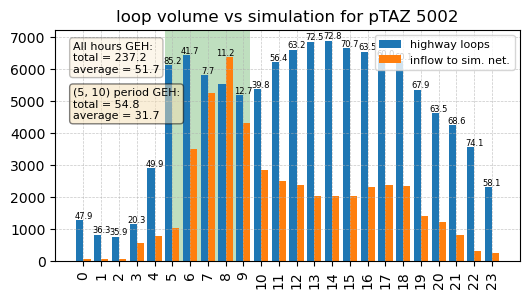

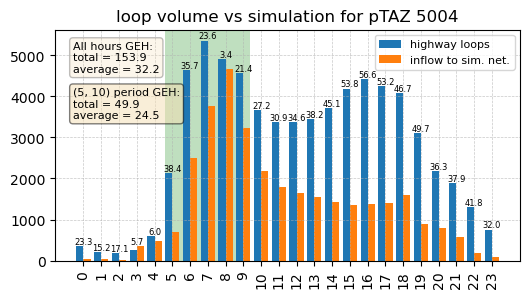

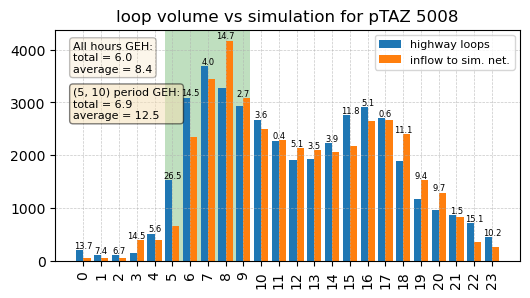

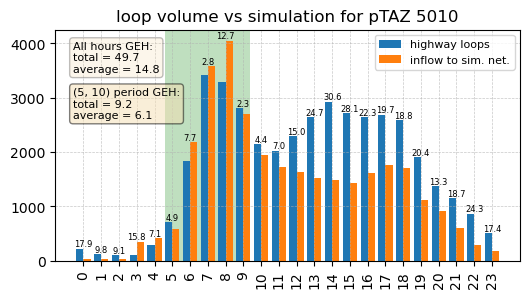

In [16]:
# origins=[5000, 5002, 5004, 5008, 5010]
origins=[5000, 5002, 5004, 5008, 5010]

for o in origins:
    volDict = get_tracflow_vol(o, show_separate=False)
    # Just the volume data
#     draw_barplot(volDict, f'Total volume for the loops in pTAZ {o}') 
    # adding simulation data:
    simDict = get_simulation_origin_dist(otaz=o, show_separate=False)
    draw_barplot(dictData=volDict, label='highway loops', 
                 dictData2=simDict, label2='inflow to sim. net.',
                 title=f'loop volume vs simulation for pTAZ {o}', start_end=(start_hour, end_hour))    

# for pTAZs outflow from the network 

## for Non-highway pTAZs

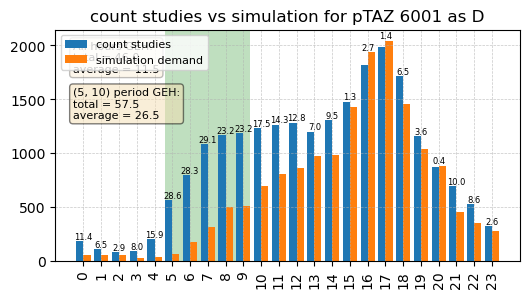

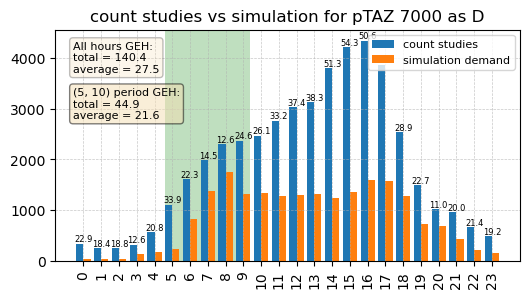

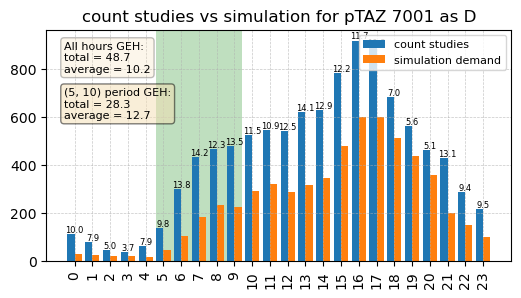

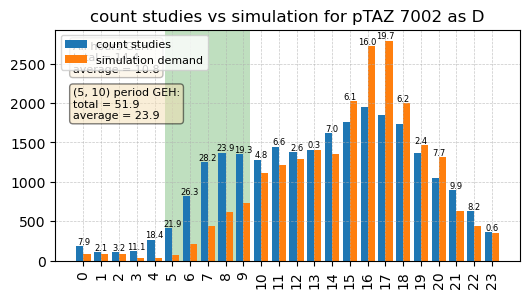

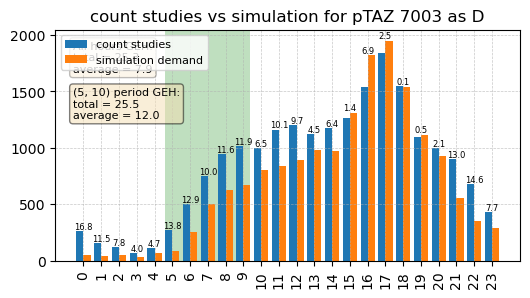

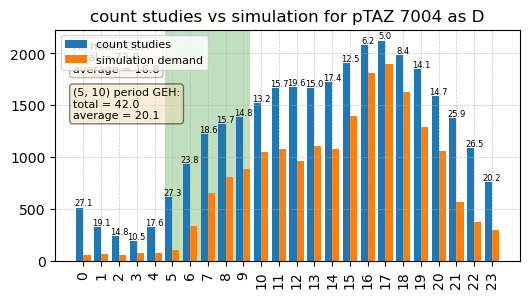

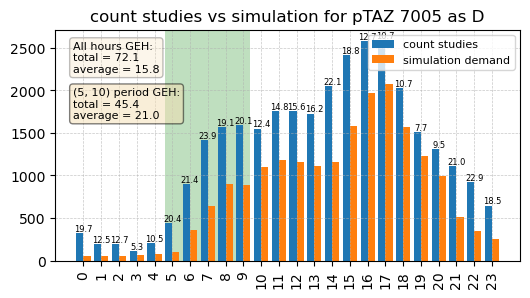

In [17]:
destinations=[6001, 7000, 7001, 7002, 7003, 7004, 7005]

for d in destinations:
    countDict = get_count_study(d, show_separate=False, destination_TAZ=True)
    # Just the count data
#     draw_barplot(countDict, f'Total volume for the list of count studies {o}') 
    
    # adding simulation data:
    simDict = get_simulation_origin_dist(dtaz=d, show_separate=False)
    draw_barplot(dictData=countDict, label='count studies', 
                 dictData2=simDict, label2='simulation demand',
                 title=f'count studies vs simulation for pTAZ {d} as D', start_end=(start_hour, end_hour))    


## for highway pTAZs

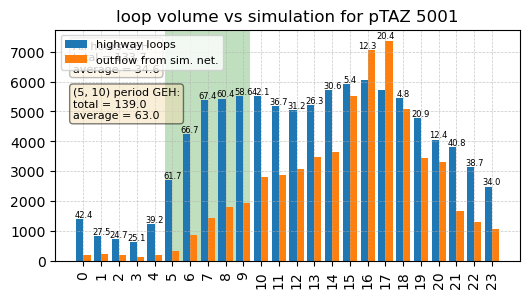

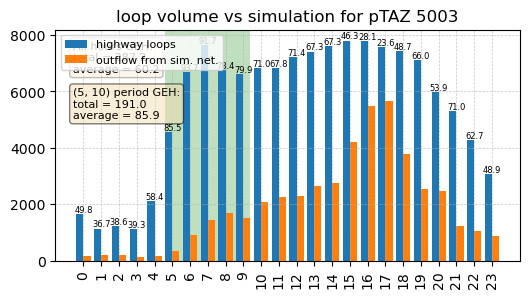

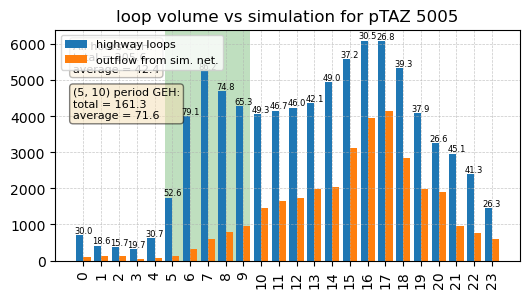

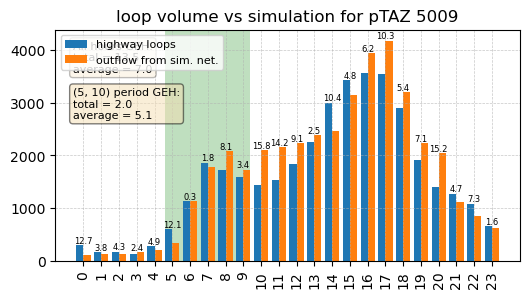

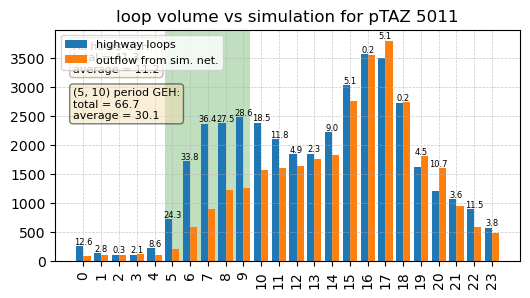

In [18]:
destinations=[5001, 5003, 5005, 5009, 5011]

for d in destinations:
    volDict = get_tracflow_vol(d, show_separate=False)
    # Just the volume data
#     draw_barplot(volDict, f'Total volume for the loops in pTAZ {o}') 
    # adding simulation data:
    simDict = get_simulation_origin_dist(dtaz=d, show_separate=False)
    draw_barplot(dictData=volDict, label='highway loops', 
                 dictData2=simDict, label2='outflow from sim. net.',
                 title=f'loop volume vs simulation for pTAZ {d}', start_end=(start_hour, end_hour))    

# For loop detectors inside the network

In [70]:
def get_simulation_loop_data(loopKey):
    flowdict = {}
    speeddict = {}
    for interval, detectors in sim_loop_dict[loopKey].items():
#         print(interval)
        flows = 0
        speeds = 0
        for loop in detectors:
#             print(f"{loop.get('id')} flow: {loop.get('flow')} veh/h, space mean speed: {loop.get('harmonicMeanSpeed')} m/s")
            flows += float(loop.get('flow'))
#             speeds += float(loop.get('flow'))/float(loop.get('harmonicMeanSpeed'))
        flows = int(flows)
#         mean_speed = round(flows/speeds*2.237,2)
        mean_speed = 0
        flowdict[interval] = flows
        speeddict[interval] = mean_speed
#         print(f"total flow: {flows} veh/h, mean speed: {mean_speed} mph")    
    return flowdict, speeddict

In [71]:
# reading loop detector xml data in the simulation
# sim_loops = ET.parse('calibration_data/loops.xml').getroot().findall('interval')
sim_loops = ET.parse('calibration_data/loops_Feb29.xml').getroot().findall('interval')

sim_loop_dict = {key:{} for key in corridor_study_dict.keys()}
for loop in sim_loops:
    loopid = loop.get('id')
    begin = int(float(loop.get('begin'))//3600)
    sim_loop_dict[loopid[:-2]].setdefault(begin, [])
    sim_loop_dict[loopid[:-2]][begin].append(loop)

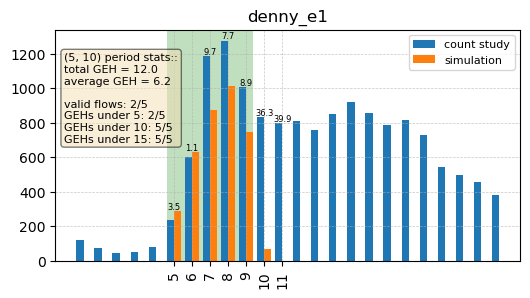

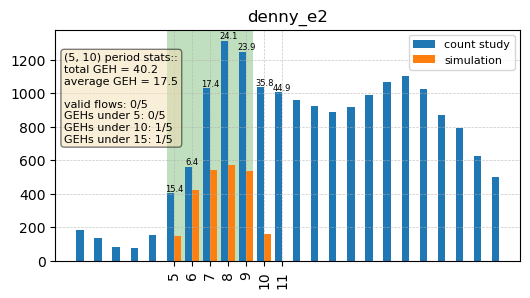

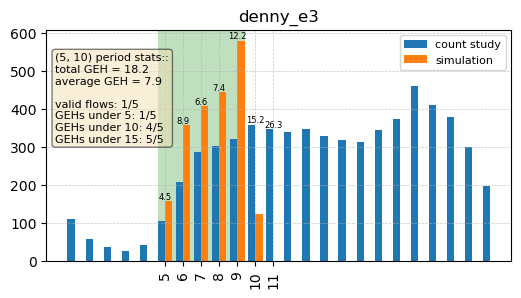

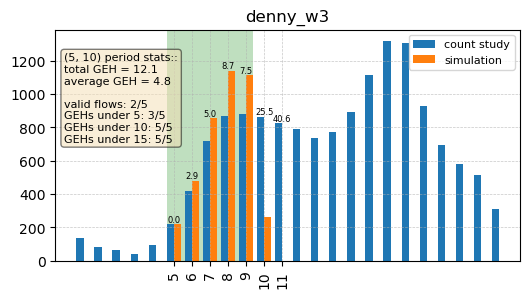

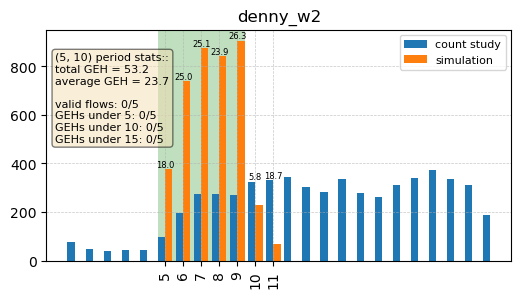

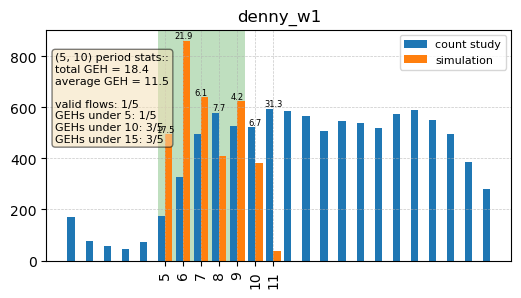

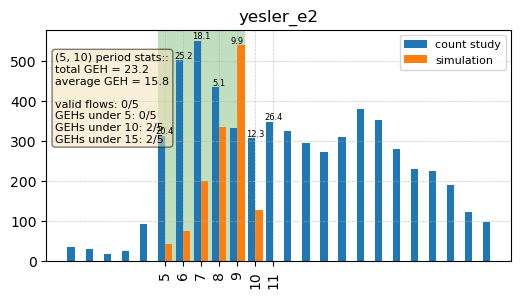

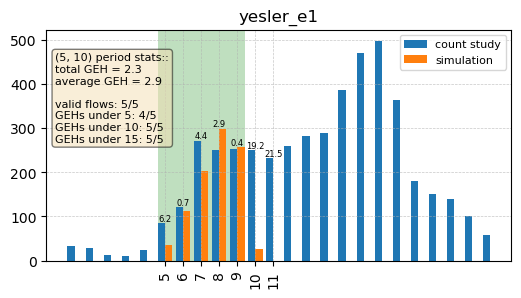

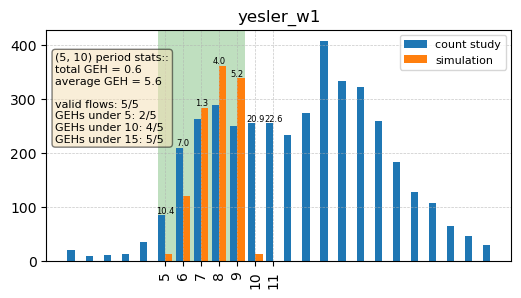

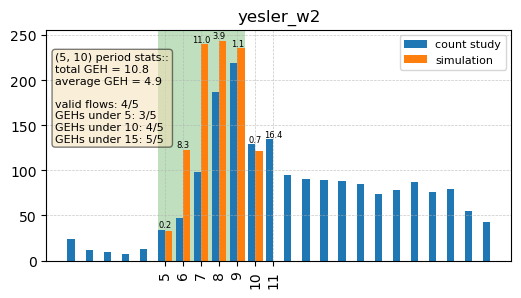

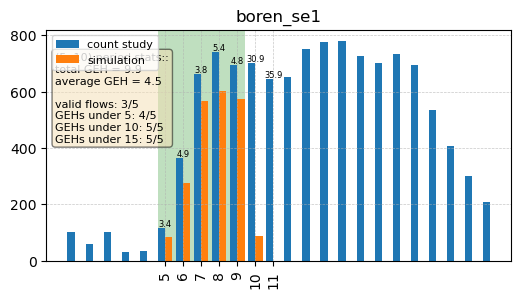

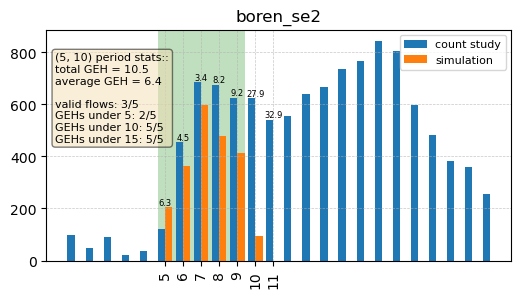

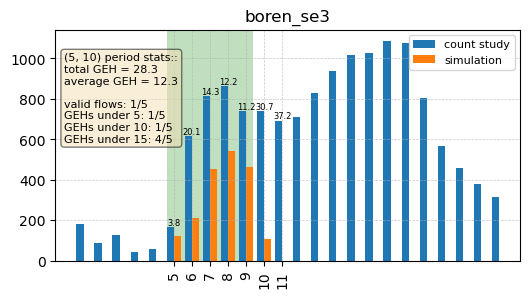

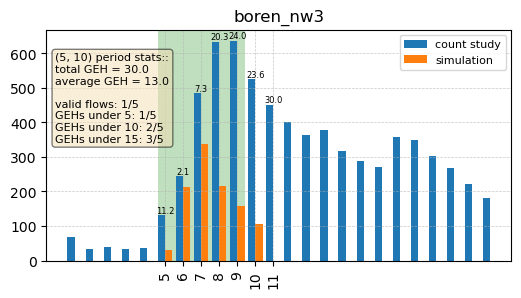

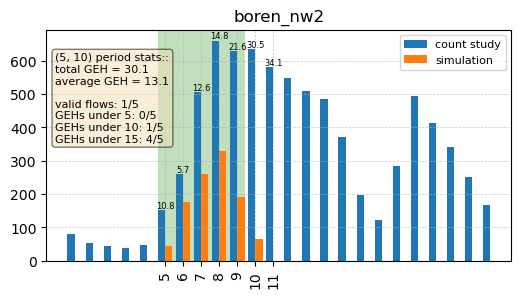

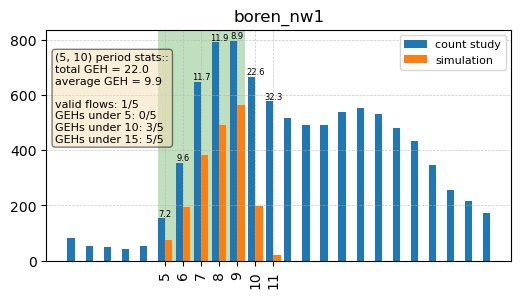

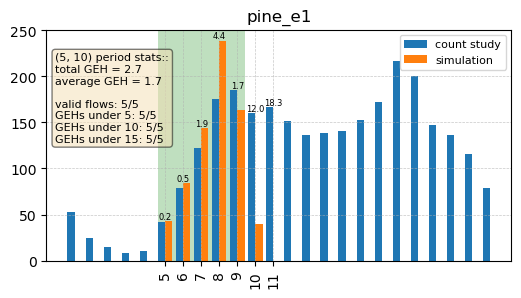

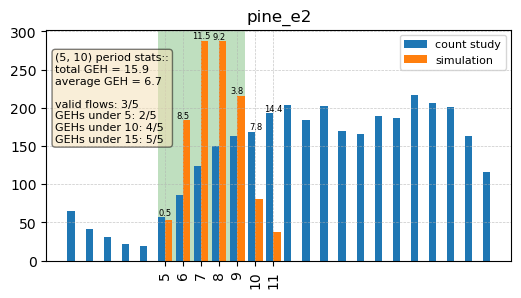

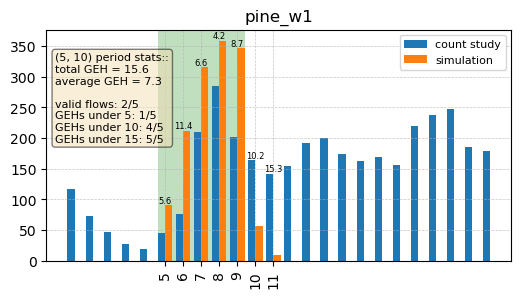

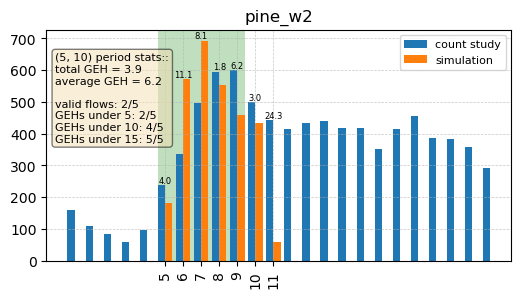

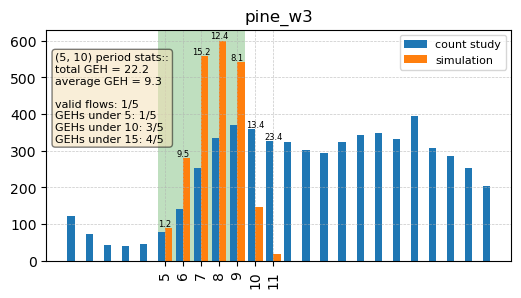

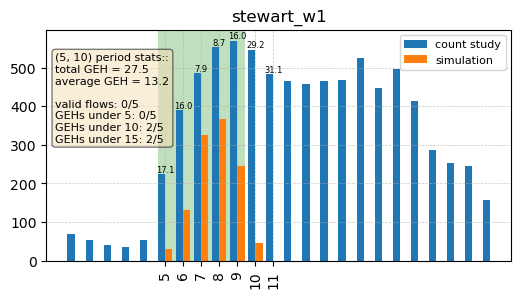

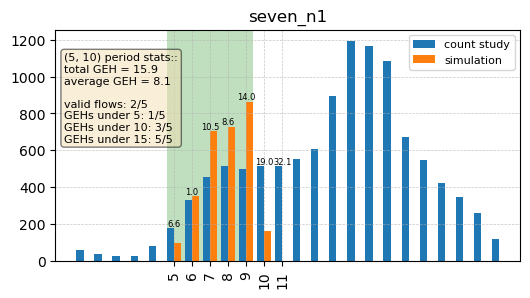

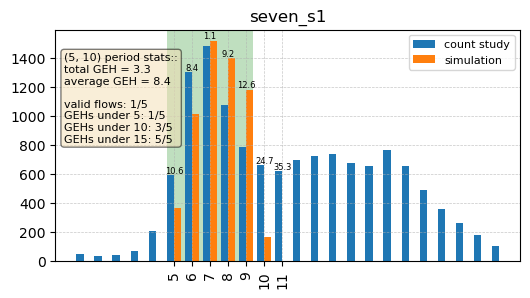

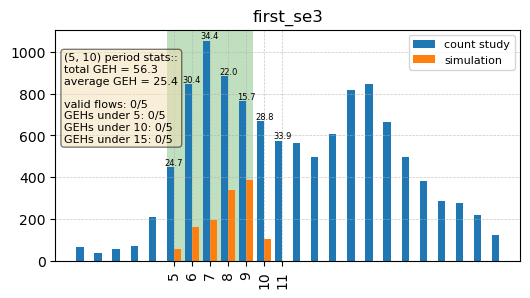

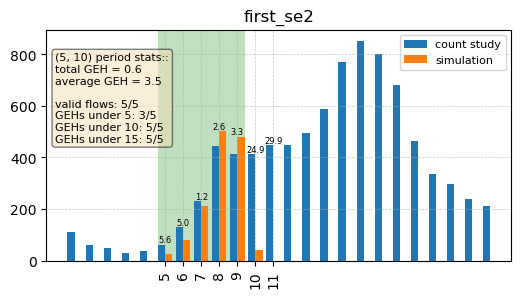

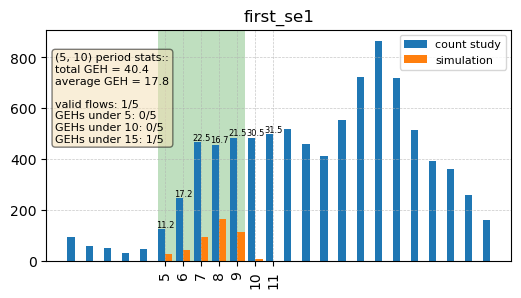

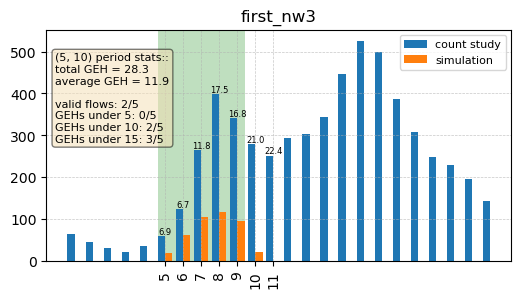

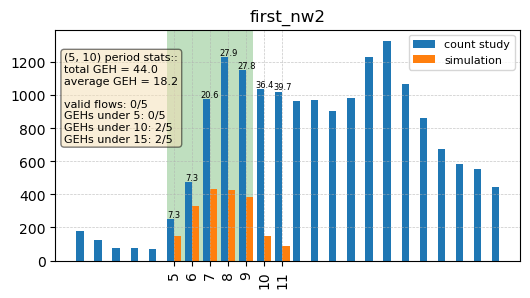

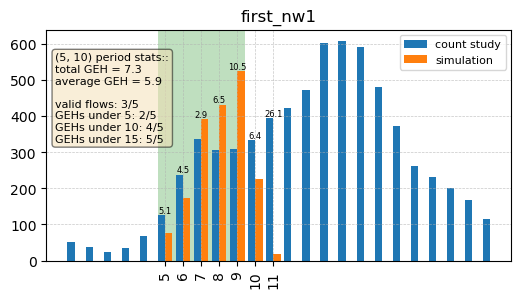

In [72]:
for c in corridor_study_dict.keys():
    count_studies_loops = get_count_study(c, corridor_check=True)
#     draw_barplot(count_studies_loops, c)
    simulation_loops = get_simulation_loop_data(loopKey=c)[0]
    draw_barplot(count_studies_loops, title=c, label='count study', 
                 dictData2=simulation_loops, label2='simulation', start_end=(start_hour, end_hour),
                show_stats=True)


# transfering demand

In [17]:
def show_all_pTAZs(demand_df):
    tazs=[5000, 5002, 5004, 5008, 5010]
    for o in tazs:
        countDict = get_tracflow_vol(o, show_separate=False)
        simDict = get_simulation_origin_dist(otaz=o, show_separate=False, demand_df=demand_df)
        draw_barplot(dictData=countDict, label='count studies', 
                     dictData2=simDict, label2='simulation demand',
                     title=f'count studies vs simulation for pTAZ {o} as O', start_end=(start_hour, end_hour), 
                    show_stats=True)

        countDict = get_tracflow_vol(o+1, show_separate=False)
        simDict = get_simulation_origin_dist(dtaz=o+1, show_separate=False,  demand_df=demand_df)
        draw_barplot(dictData=countDict, label='count studies', 
                     dictData2=simDict, label2='simulation demand',
                     title=f'count studies vs simulation for pTAZ {o+1} as D', start_end=(start_hour, end_hour),
                    show_stats=True)
        print('----------\n')
        
    tazs=[6001, 7000, 7001, 7002, 7003, 7004, 7005]
    for o, d in zip(tazs, tazs):
        countDict = get_count_study(o, show_separate=False, destination_TAZ=False)
        simDict = get_simulation_origin_dist(otaz=o, show_separate=False, demand_df=demand_df)
        draw_barplot(dictData=countDict, label='count studies', 
                     dictData2=simDict, label2='simulation demand',
                     title=f'count studies vs simulation for pTAZ {o} as O', start_end=(start_hour, end_hour),
                    show_stats=True)

        countDict = get_count_study(d, show_separate=False, destination_TAZ=True)
        simDict = get_simulation_origin_dist(dtaz=d, show_separate=False,  demand_df=demand_df)
        draw_barplot(dictData=countDict, label='count studies', 
                     dictData2=simDict, label2='simulation demand',
                     title=f'count studies vs simulation for pTAZ {d} as D', start_end=(start_hour, end_hour),
                    show_stats=True)
        print('----------\n')



In [18]:
# read regions
def read_region(address):
    with open(address, 'r') as f:
        content = f.read()
        data_list = eval(content)
    return data_list

industrial = read_region('calibration_data/regions/industrial.txt')
northeast = read_region('calibration_data/regions/northeast.txt')
northwest = read_region('calibration_data/regions/northwest.txt')
southeast = read_region('calibration_data/regions/southeast.txt')
north = read_region('calibration_data/regions/north.txt')

In [19]:
def transfer(df, fromTAZ, toTAZ, destinations, percentage, hour=None):
    trips = df[(df.otaz == fromTAZ)]
    if destinations is not None:
        trips = trips[(trips.dtaz.isin(destinations))]
    if hour is not None:
        trips = trips[trips.deptm//60==hour]
                       
    selected = trips.sample(int(percentage/100*len(trips)))
#     print('---\n')
#     print(selected.index)
    df.loc[selected.index, 'otaz'] = toTAZ


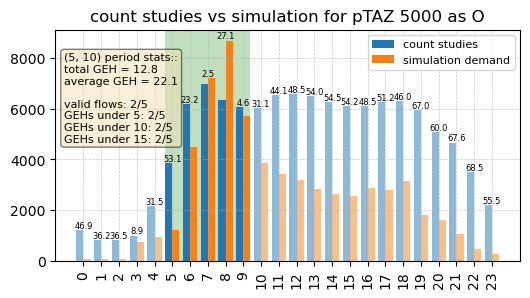

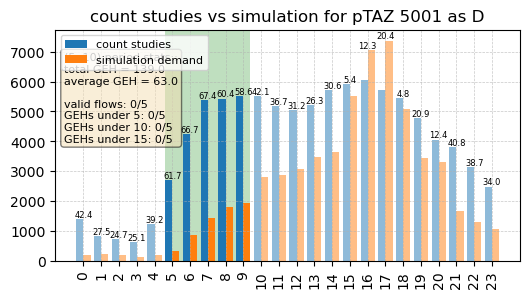

----------


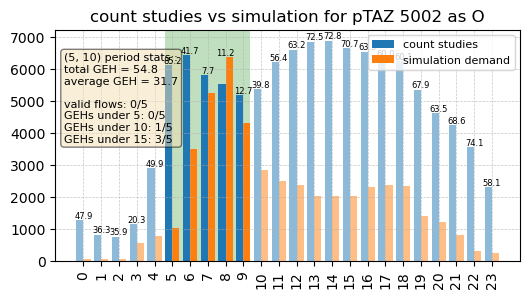

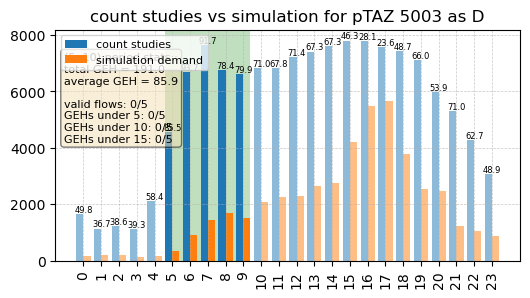

----------


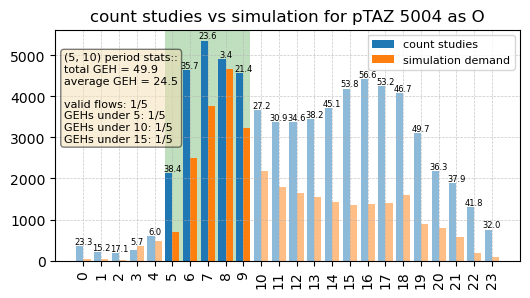

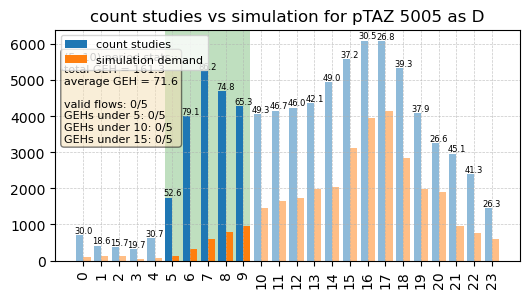

----------


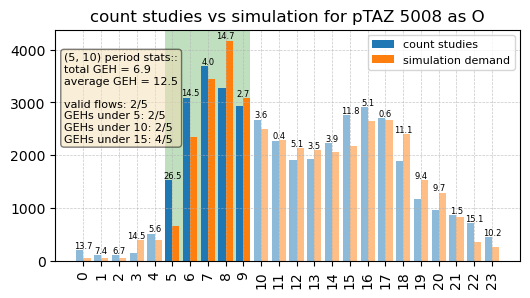

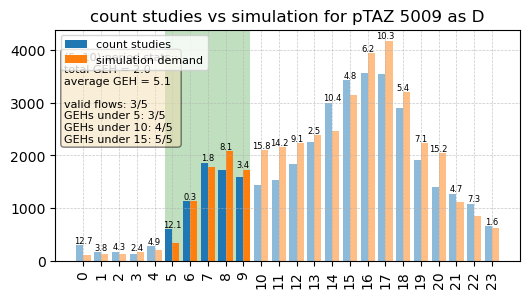

----------


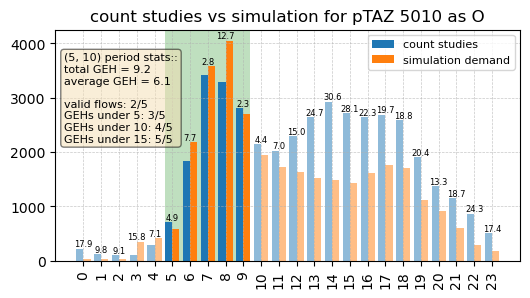

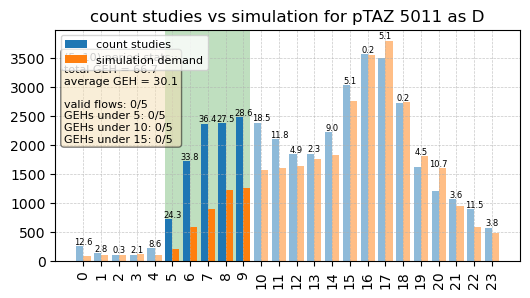

----------


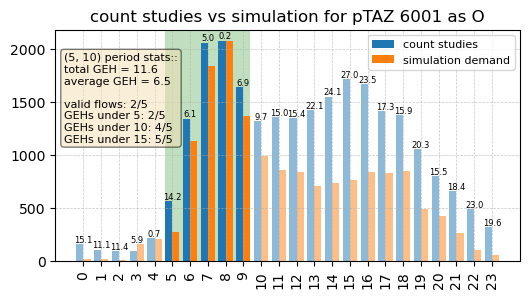

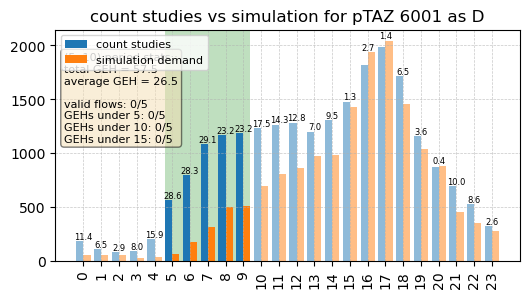

----------


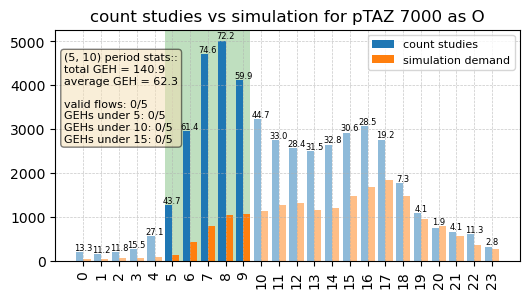

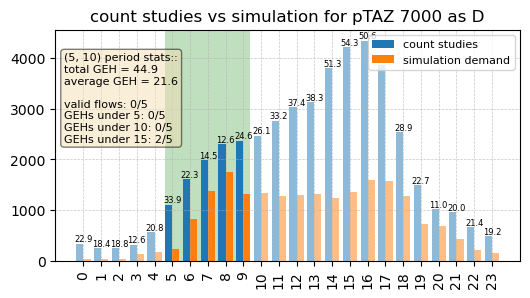

----------


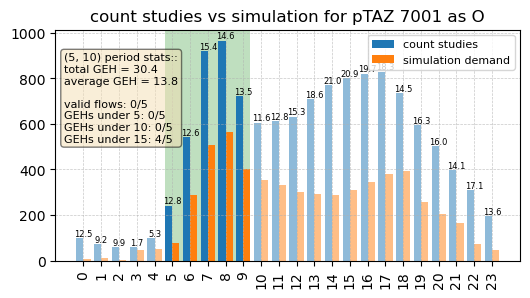

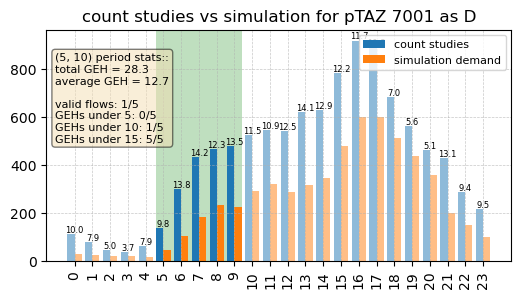

----------


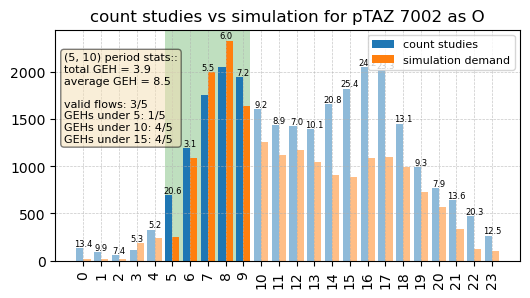

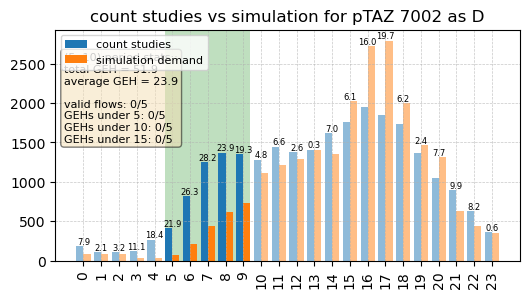

----------


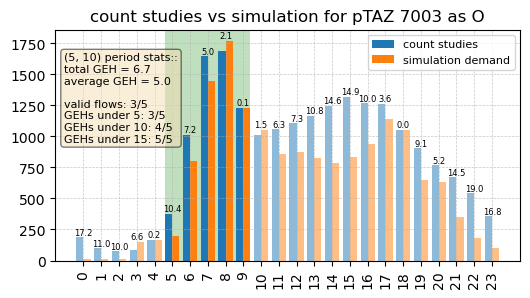

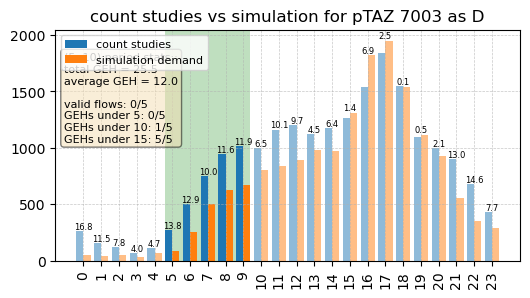

----------


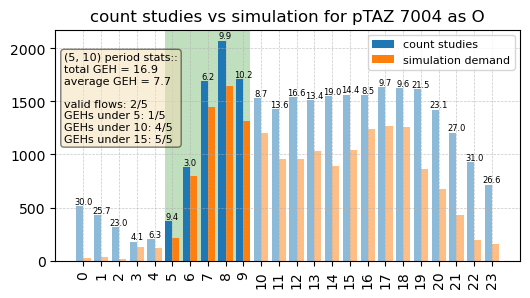

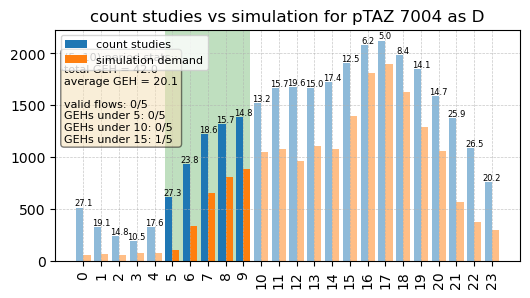

----------


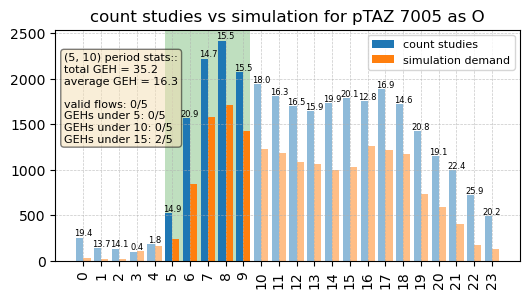

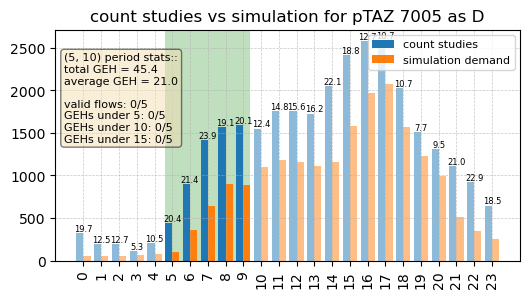

----------


In [33]:
show_all_pTAZs(demand_data)

In [34]:
demand_data_transfered = demand_data.copy()

lookup = [[5000, 7003, northwest, 25, 8], 
          [5000, 7001, northeast, 25, 7], [5000, 7001, northeast, 40, 8], [5000, 7001, northeast, 25, 9],
          [5000, 7002, north, 20, 9],
          [5000, 7004, northeast, 30, 8], 
          [5000, 7005, southeast, 30, 8],
          [5002, 7000, industrial, 50, 7], [5002, 7000, industrial, 50, 8], 
          [5002, 7005, southeast, 30, 8], [5002, 7005, southeast, 25, 7],
          [5004, 7005, southeast, 20, 8],
          [5008, 7000, None, 10, 8],
          [5008, 7000, industrial, 40, 7], [5008, 7000, industrial, 60, 8], [5008, 7000, industrial, 40, 9],
         [5008, 5002, [5001], 30, 9], [5008, 5002, None, 10, 6], [5008, 5002, None, 10, 7], [5008, 5002, None, 15, 9],
         [5010, 7001, northeast, 40, 8], [5010, 7001, northeast, 40, 7], [5010, 7001, northeast, 40, 6],
         [7002, 7001, northeast, 40, 8], [7002, 7001, northeast, 40, 7], [7002, 7001, northeast, 40, 6],
         [7003, 7001, northeast, 25, 9], [7003, 7001, northeast, 25, 8],
         [7004, 7005, None, 15, 6]]

for i in tqdm(lookup):
    transfer(demand_data_transfered, i[0], i[1], i[2], i[3], hour=i[4])

100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 376.28it/s]


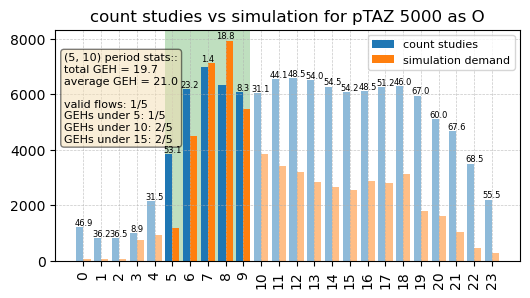

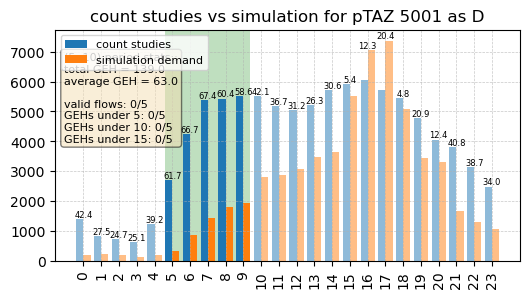

----------


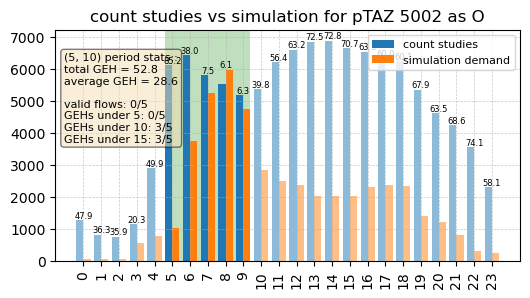

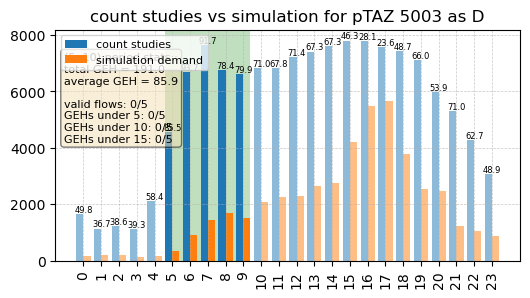

----------


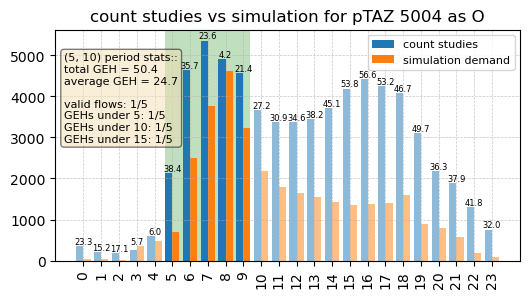

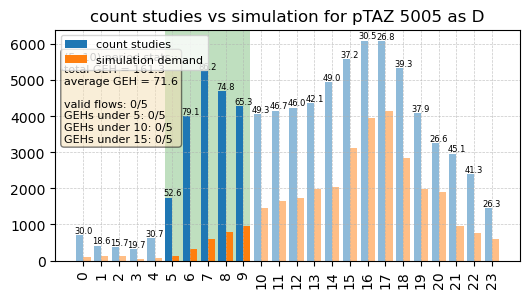

----------


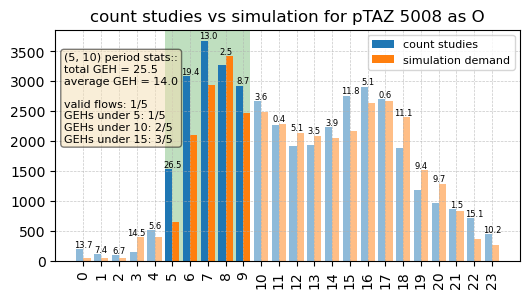

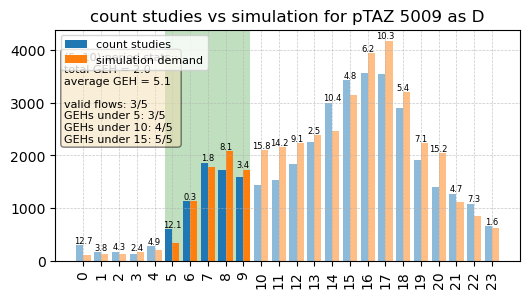

----------


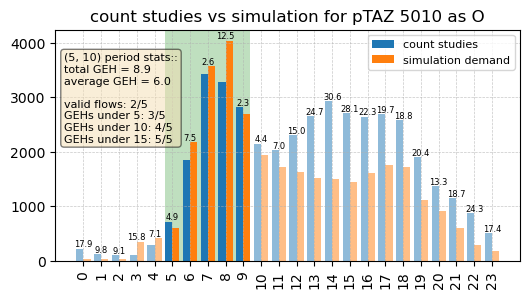

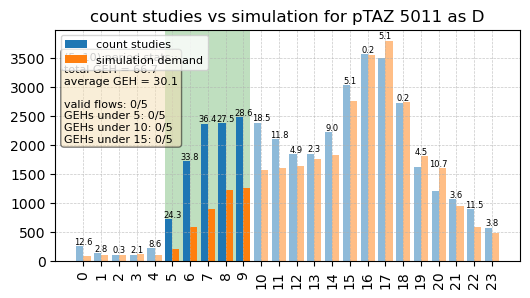

----------


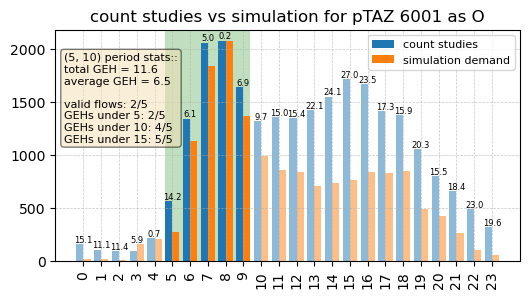

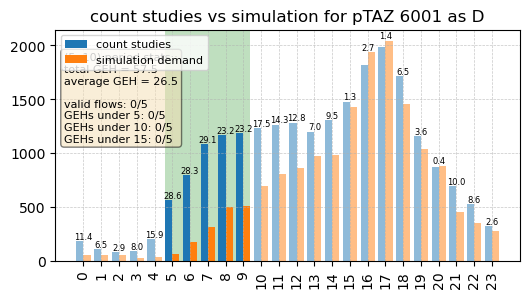

----------


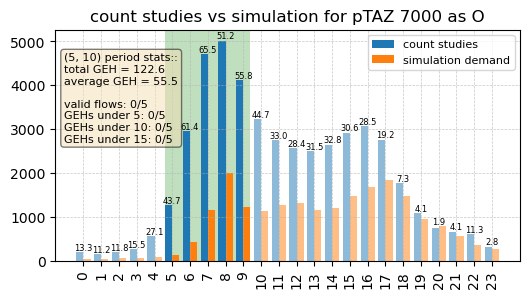

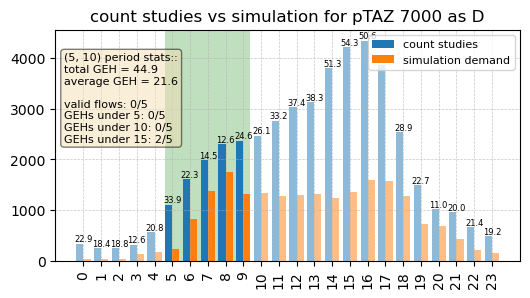

----------


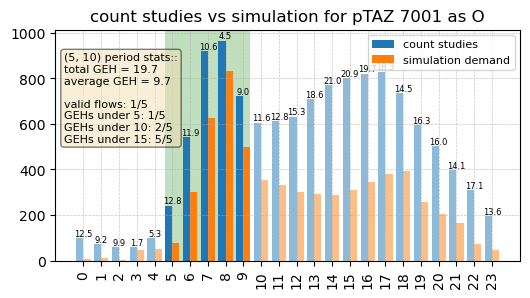

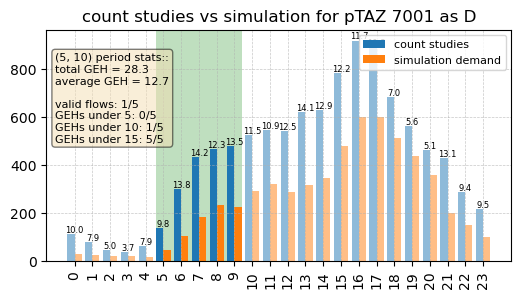

----------


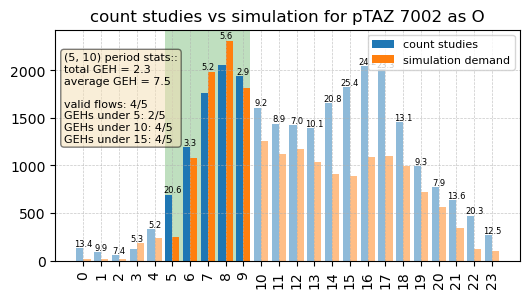

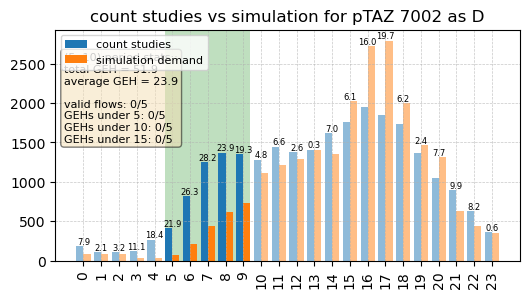

----------


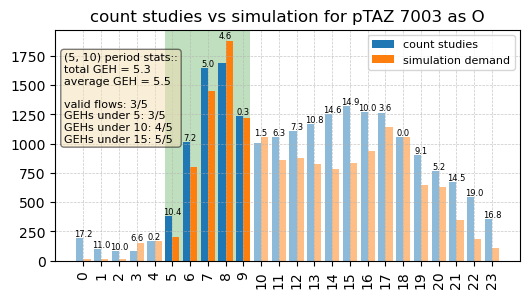

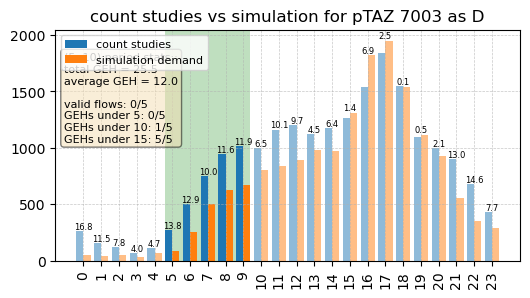

----------


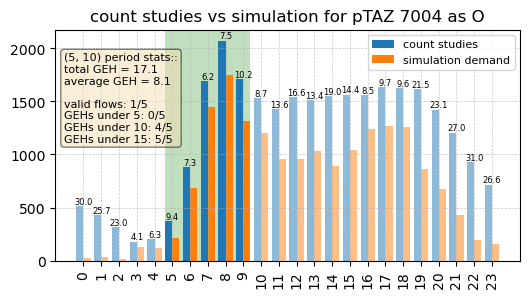

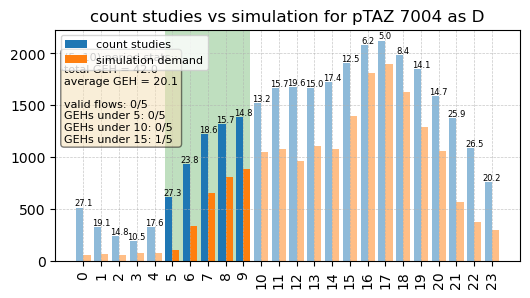

----------


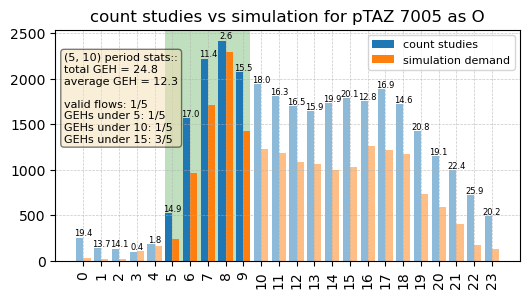

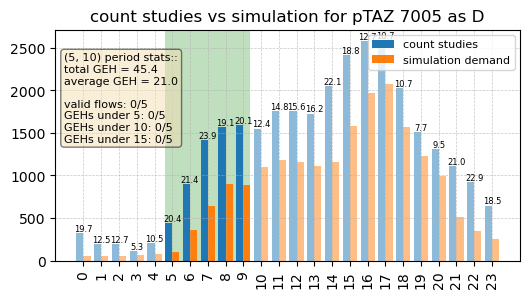

----------


In [35]:
show_all_pTAZs(demand_data_transfered)

# synthesis

In [366]:
def get_new_data(df, percent, idx_prefix=None):
    num = int(len(df)*percent/100)
    new_df = df.sample(num, replace=True).copy()
    new_df.index = new_df.index.map(lambda x: idx_prefix+str(x))
#     for i, number in enumerate(numbers_to_add):
#         df.index = df.index.insert(i, df.index[i] + number)
    
    # adjust time with a normal distritbution (95%CI: -15 minutes:+15minutes)
    time_offset = np.random.normal(loc=0.0, scale=7.5, size=len(new_df))
    new_df['original_deptm'] = new_df['deptm'].astype(str) +' ' + time_offset.astype(str)
    new_df['deptm'] = new_df['deptm'] + time_offset.astype(int)
    return new_df

In [547]:
demand_data_transfered_synthesised = demand_data_transfered.copy()

# changes_dict_origin = {5000: {5: 120, 6: 30, 7: 0, 8: 0, 9:0 },
#                        5002: {5: 300, 6:50, 7: 0, 8:0, 9: 0},
#                        5004: {5: 150, 6: 50, 7: 20, 8: 0, 9: 20},
#                        5008: {5: 80, 6: 10, 7: 0, 8: 0, 9: 0},
#                        5010: {5: 0, 6: 0, 7: 0, 0: 0, 9: 0},
#                        6001: {5: 50, 6: 0, 7: 0, 8: 0, 9: 0},
#                        7000: {5: 400, 6:350, 7: 200, 8:100, 9: 100},
#                        7001: {5: 110, 6: 50, 7: 60, 8: 25, 9: 50},
#                        7002: {5: 100, 6: 0, 7: 0, 8: 0, 9: 0},
#                        7003: {5: 50, 6: 10, 7: 0, 8: 0, 9: 0}, 
#                        7004: {5: 25, 6: 0, 7: 0, 8: 0, 9: 0},
#                        7005: {5: 60, 6: 40, 7: 10, 8: 0, 9: 30}
#                       }

# changes_dict_dest = {5001: {5: 300, 6: 200, 7: 150, 8: 150, 9: 150},
#                      5003: {5: 300, 6:300, 7: 300, 8:300, 9: 300},
#                      5005: {5: 300, 6:300, 7: 300, 8:300, 9: 300},
#                      5009: {5: 100, 6: 0, 7: 0, 8: 0, 9: 0},
#                      5011: {5: 200, 6: 100, 7:100, 8: 80, 9: 80},
#                      6001: {5: 100, 6: 100, 7: 200, 8: 100, 9: 100},
#                      7000: {5: 100, 6:20, 7: 10, 8:10, 9: 20},
#                      7001: {5: 100, 6: 100, 7: 100, 8: 100, 9: 100},
#                      7002: {5: 200, 6: 200, 7: 150, 8: 100, 9: 80},
#                      7003: {5: 100, 6: 50, 7: 20, 8: 20, 9: 20}, 
#                      7004: {5: 300, 6: 100, 7: 50, 8: 50, 9: 25},
#                      7005: {5: 100, 6: 100, 7: 100, 8: 60, 9: 60}
#                     }

# #max200
# changes_dict_origin = {5000: {5: 200, 6: 10, 7: 0, 8: 0, 9:0},
#                        5002: {5: 200, 6:50, 7: 5, 8:0, 9: 0},
#                        5004: {5: 180, 6: 70, 7: 30, 8: 0, 9: 20},
#                        5008: {5: 80, 6: 0, 7: 0, 8: 0, 9: 0},
#                        5010: {5: 0, 6: 0, 7: 0, 0: 0, 9: 0},
#                        6001: {5: 40, 6: 0, 7: 0, 8: 0, 9: 0},
#                        7000: {5: 200, 6:200, 7: 200, 8:200, 9: 200},
#                        7001: {5: 140, 6: 55, 7: 40, 8: 0, 9: 30},
#                        7002: {5: 160, 6: 0, 7: 0, 8: 0, 9: 0},
#                        7003: {5: 25, 6: 10, 7: 0, 8: 0, 9: 0}, 
#                        7004: {5: 0, 6: 0, 7: 0, 8: 0, 9: 0},
#                        7005: {5: 50, 6: 30, 7: 0, 8: 0, 9: 20}
#                       }


# changes_dict_dest = {5001: {5: 200, 6: 200, 7: 200, 8: 180, 9: 165},
#                      5003: {5: 200, 6:200, 7: 200, 8:200, 9: 200},
#                      5005: {5: 200, 6:200, 7: 200, 8:200, 9: 200},
#                      5009: {5: 50, 6: 0, 7: 0, 8: 0, 9: 0},
#                      5011: {5: 160, 6: 170, 7:140, 8: 80, 9: 80},
#                      6001: {5: 200, 6: 200, 7: 200, 8: 100, 9: 90},
#                      7000: {5: 200, 6:60, 7: 20, 8:25, 9: 65},
#                      7001: {5: 120, 6: 120, 7: 95, 8: 60, 9: 75},
#                      7002: {5: 200, 6: 200, 7: 175, 8: 90, 9: 60},
#                      7003: {5: 130, 6: 60, 7: 30, 8: 25, 9: 25}, 
#                      7004: {5: 200, 6: 140, 7: 70, 8: 55, 9: 40},
#                      7005: {5: 185, 6: 100, 7: 100, 8: 60, 9: 65}
#                     }


#max150
changes_dict_origin = {5000: {5: 150, 6: 10, 7: 0, 8: 0, 9:0},
                       5002: {5: 150, 6:45, 7: 0, 8:0, 9: 0},
                       5004: {5: 150, 6: 60, 7: 25, 8: 8, 9: 20},
                       5008: {5: 80, 6: 0, 7: 0, 8: 0, 9: 0},
                       5010: {5: 0, 6: 0, 7: 0, 0: 0, 9: 0},
                       6001: {5: 40, 6: 0, 7: 0, 8: 0, 9: 0},
                       7000: {5: 150, 6:150, 7: 150, 8:150, 9: 150},
                       7001: {5: 100, 6: 55, 7: 35, 8: 0, 9: 30},
                       7002: {5: 100, 6: 0, 7: 0, 8: 0, 9: 0},
                       7003: {5: 30, 6: 10, 7: 0, 8: 0, 9: 0}, 
                       7004: {5: 10, 6: 0, 7: 0, 8: 0, 9: 0},
                       7005: {5: 45, 6: 10, 7: 0, 8: 0, 9: 10}
                      }


changes_dict_dest = {5001: {5: 150, 6: 150, 7: 150, 8: 150, 9: 150},
                     5003: {5: 150, 6:150, 7: 150, 8:150, 9: 150},
                     5005: {5: 150, 6:150, 7: 150, 8:150, 9: 150},
                     5009: {5: 50, 6: 0, 7: 0, 8: 0, 9: 0},
                     5011: {5: 150, 6: 150, 7:140, 8: 80, 9: 80},
                     6001: {5: 150, 6: 150, 7: 150, 8: 105, 9: 100},
                     7000: {5: 150, 6:65, 7: 20, 8:20, 9: 50},
                     7001: {5: 100, 6: 100, 7: 75, 8: 45, 9: 60},
                     7002: {5: 150, 6: 150, 7: 120, 8: 90, 9: 60},
                     7003: {5: 100, 6: 60, 7: 30, 8: 30, 9: 30}, 
                     7004: {5: 150, 6: 100, 7: 50, 8: 35, 9: 20},
                     7005: {5: 150, 6: 70, 7: 80, 8: 45, 9: 45}
                    }

for pTAZ, changes in tqdm(changes_dict_origin.items()):
    for hour, percent in changes.items():        
        trips_o = demand_data[(demand_data.otaz == pTAZ) & (demand_data.deptm//60==hour)]
        new_d = get_new_data(trips_o, percent, idx_prefix=f'synthO{pTAZ}:')
        demand_data_transfered_synthesised = pd.concat([demand_data_transfered_synthesised, new_d])

for pTAZ, changes in tqdm(changes_dict_dest.items()):
    for hour, percent in changes.items():        
        trips_d = demand_data[(demand_data.dtaz == pTAZ) & (demand_data.deptm//60==hour)]
        new_d = get_new_data(trips_d, percent, idx_prefix=f'synthD{pTAZ}:')
        demand_data_transfered_synthesised = pd.concat([demand_data_transfered_synthesised, new_d])
        

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.49it/s]


In [548]:
demand_data_transfered_synthesised

otaz  dtaz  deptm  travtime  original_o  original_d  \
0                  7001   428    520        27           1         428   
1                  7002   432    324        20           1         432   
2                  7002   432    380        24           1         432   
3                  7002   432    523        26           1         432   
4                  7002   432    532        26           1         432   
...                 ...   ...    ...       ...         ...         ...   
synthD7005:286328   514  7005    577         9         514         626   
synthD7005:425793   627  7005    592         6         627         649   
synthD7005:390295   584  7005    595         7         584         616   
synthD7005:453723   650  7005    603        10         650         638   
synthD7005:412553   611  7005    563         9         611         617   

                             original_deptm  
0                                       498  
1                                       304  
2                                       360  
3                                       501  
4                                       510  
...                                     ...  
synthD7005:286328     573 4.476366965100771  
synthD7005:425793    589 3.6880439070515254  
synthD7005:390295   595 -0.5764501902419733  
synthD7005:453723    596 7.1384119911947534  
synthD7005:412553  563 -0.09517955132080134  

[734038 rows x 7 columns]

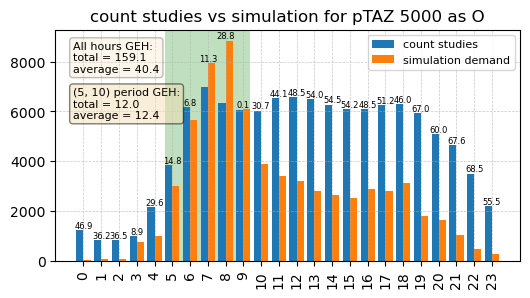

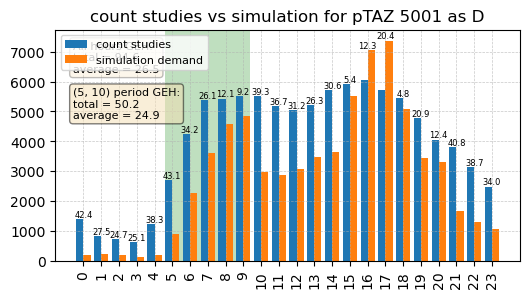

----------


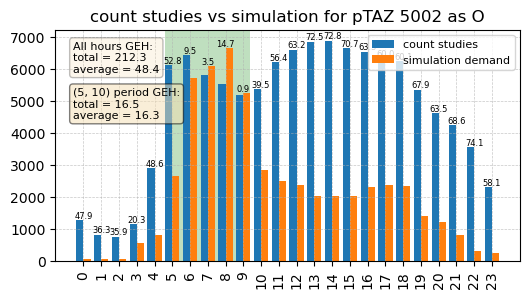

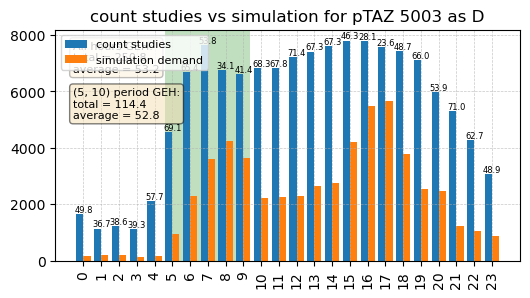

----------


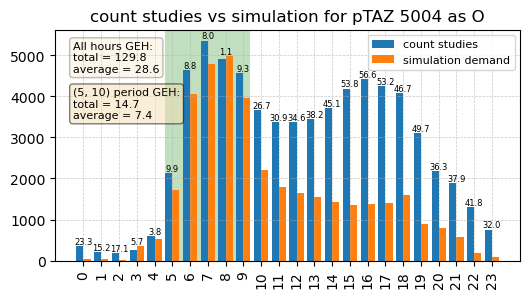

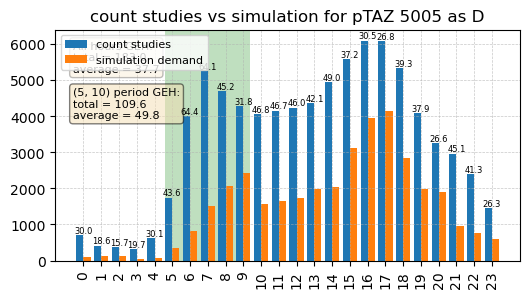

----------


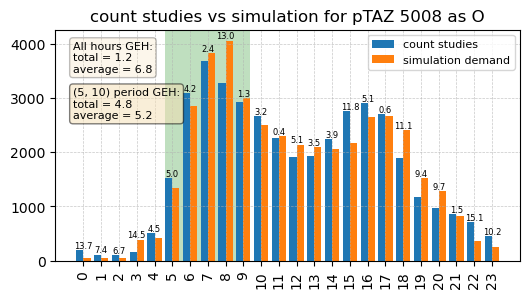

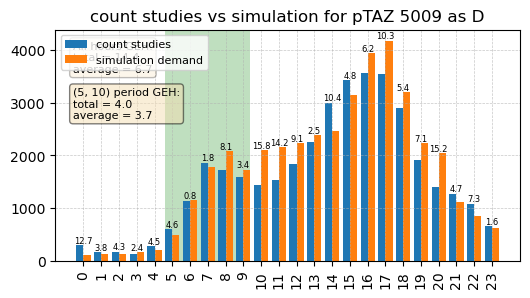

----------


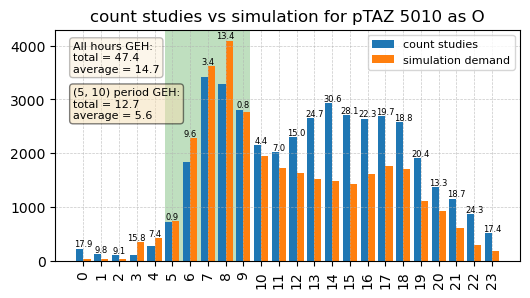

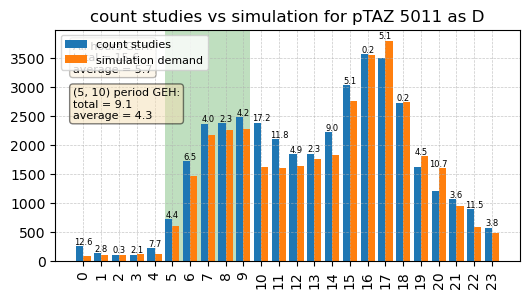

----------


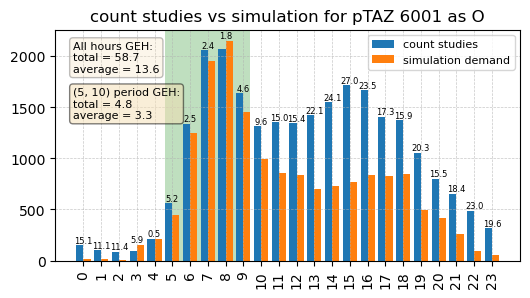

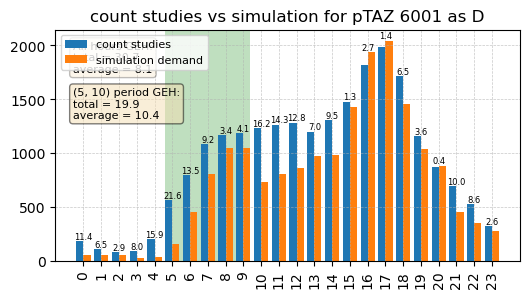

----------


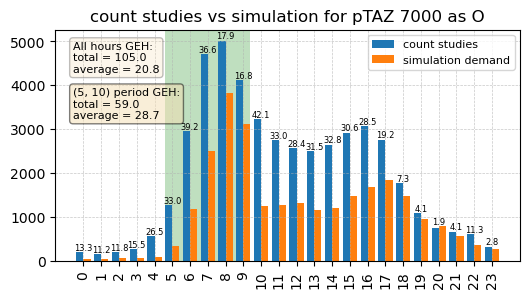

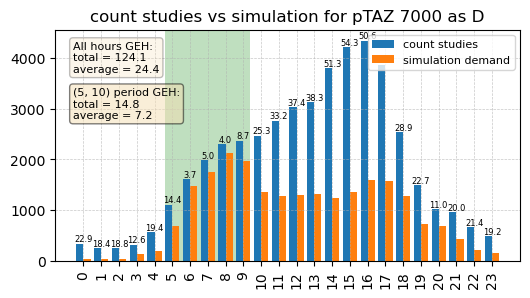

----------


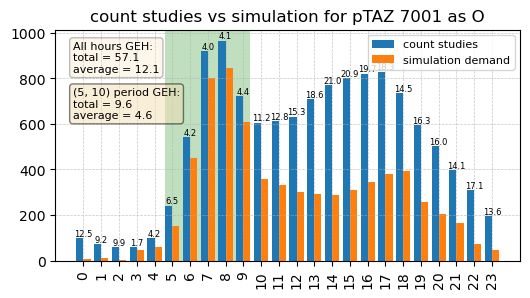

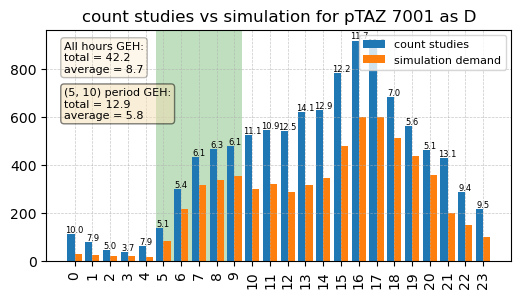

----------


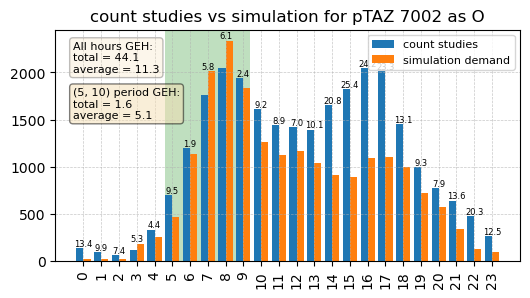

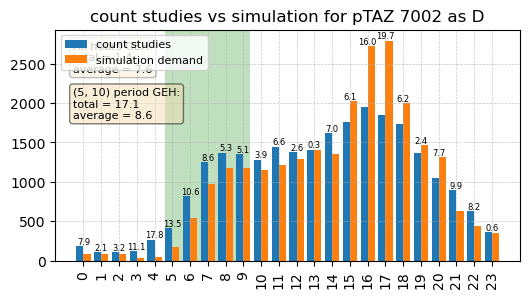

----------


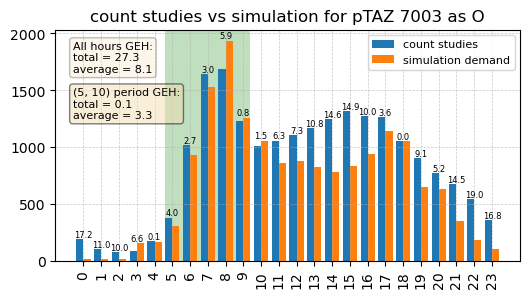

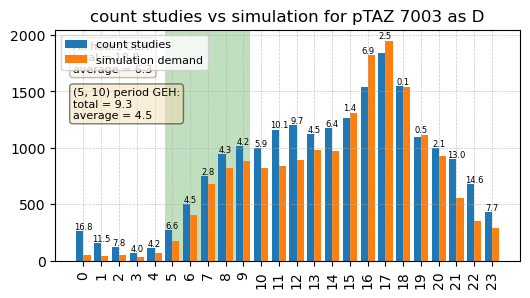

----------


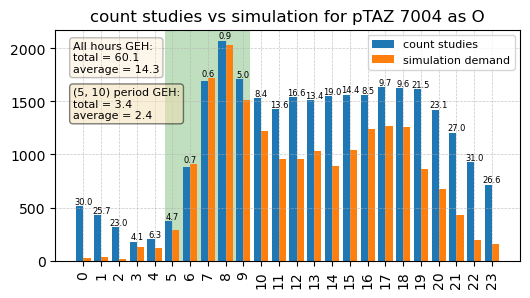

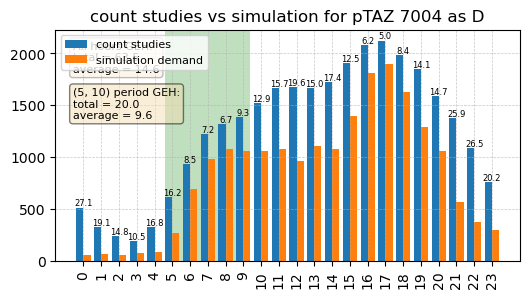

----------


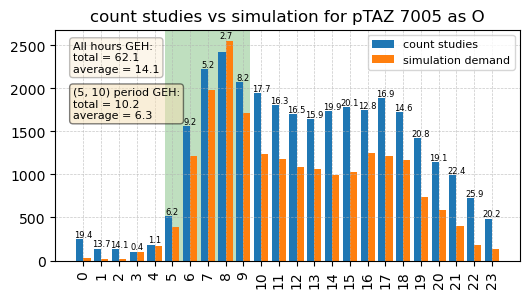

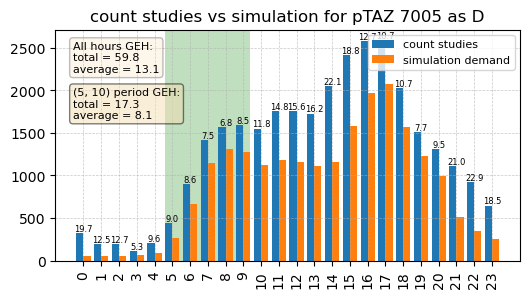

----------


In [549]:
show_all_pTAZs(demand_data_transfered_synthesised)

# reduction

In [526]:
def reduce_demand(df, otaz, percent, hour):
    trips = df[(df.otaz==otaz) & (df.deptm//60==hour)]
    selected = trips.sample(int(len(trips)*percent/100))
    df.drop(selected.index, inplace=True)
    

In [550]:
demand_data_transfered_synthesised_reduced = demand_data_transfered_synthesised.copy()
lookup = [[5000, 5, 7], [5000, 25, 8], [5000, 5, 9],
          [5000, 10, 7],
          [5002, 25, 8], [5002, 12, 7],  [5002, 15, 9],
           [5004, 3, 7],
         [5008, 18, 8],
         [5010, 5, 9], [5010, 25, 8], [5010, 10, 7],  [5010, 15, 6],
         [7002, 5, 9], [7002, 20, 8], [7002, 20, 7],
         [7003, 10, 8],
         [7004, 10, 8], [7004, 10, 7],
         [7005, 13, 8]]

for i in tqdm(lookup):
    reduce_demand(demand_data_transfered_synthesised_reduced, i[0], i[1], i[2])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.65it/s]


In [51]:
show_all_pTAZs(demand_data_transfered_synthesised_reduced)

NameError: name 'show_all_pTAZs' is not defined

In [552]:
demand_data_transfered_synthesised_reduced

otaz  dtaz  deptm  travtime  original_o  original_d  \
0                  7001   428    520        27           1         428   
1                  7002   432    324        20           1         432   
2                  7002   432    380        24           1         432   
4                  7002   432    532        26           1         432   
5                  7002   432    563        25           1         432   
...                 ...   ...    ...       ...         ...         ...   
synthD7005:286328   514  7005    577         9         514         626   
synthD7005:425793   627  7005    592         6         627         649   
synthD7005:390295   584  7005    595         7         584         616   
synthD7005:453723   650  7005    603        10         650         638   
synthD7005:412553   611  7005    563         9         611         617   

                             original_deptm  
0                                       498  
1                                       304  
2                                       360  
4                                       510  
5                                       541  
...                                     ...  
synthD7005:286328     573 4.476366965100771  
synthD7005:425793    589 3.6880439070515254  
synthD7005:390295   595 -0.5764501902419733  
synthD7005:453723    596 7.1384119911947534  
synthD7005:412553  563 -0.09517955132080134  

[721697 rows x 7 columns]

In [553]:
demand_data_transfered_synthesised_reduced.to_csv('psrc_vehicle_trips_converted_taz_calibrated_v2.csv', index=False)

# in-network calibration

### first run the simulation with the data generated in the previous out_of_network calibration
### then look at vehroute output: when you want to reduce the demand in a specific corridor, you look at the trips that actually used this corridor (edge) 
### then you decide to delete or synthesise sampled trips in a specific hour. But the changes should be in the output of od2trips demand generation tool from the results of this file